# __Asteroid Diameter Prediction__

## Introduction

Asteroids are small, rocky objects that revolve around the Sun in elliptical orbits. They are sometimes called minor planets or planetoids and are remnants left over from the early formation of our solar system about 4.6 billion years ago. 

Asteroids range in size from tiny specks to hundreds of kilometers across, and they are located primarily in the asteroid belt between Mars and Jupiter, though, they can also be observed in other regions of the solar system. Most asteroids are irregularly shaped, only some of them are close to spherical, and they are often pitted or cratered. But wait, what do we mean by the diameter of the asteroid if it is of irregular shape?

Basically, the diameter of an asteroid of irregular shape is usually represented by its __equivalent diameter__, which is the diameter of a sphere that has the same volume as the asteroid. This equivalent diameter is a handy way to compare the size of different asteroids, but it should be noted that it does not necessarily represent the actual physical size or shape of the asteroid. In some cases, the equivalent diameter may be an overestimate or an underestimate of the true size of the asteroid, depending on its shape and density.

There are __two classes of asteroids__ that are of particular interest to astronomers and planetary scientists: __NEAs and PHAs__. NEAs stands for __"Near-Earth Asteroids"__, and, as the name suggests, these are asteroids that come relatively close to Earth's orbit, meaning they have the potential to collide with Earth. On the other hand, PHA stands for __"Potentially Hazardous Asteroids"__ and these are a subset of NEAs that are particularly worrisome because they have the potential to come even closer to Earth's orbit, and their size is big enough that they could cause significant damage if they were to collide with Earth.

Apart from other reasons, diameter prediction is extremely important for identifying NEAs and PHAs, since the size of an asteroid can have a big impact on how it interacts with Earth. Smaller asteroids are more likely to burn up in Earth's atmosphere before reaching the surface, while larger asteroids can cause more damage upon impact. By predicting the diameter of NEAs and PHAs, scientists can better assess the potential threat these asteroids pose to Earth and develop strategies to diminish any potential harm. In addition, the diameter prediction can also provide valuable information about the composition, structure, and evolution of asteroids, which can lead to a deeper understanding of the origins of the Solar System we live in.

## Problem Statement and Motivation

This project aims to estimate the size of asteroids in our solar system based on various observable characteristics such as their absolute magnitude, albedo, distance from the Sun, and their orbital parameters. Accurately predicting the size of asteroids is crucial for understanding their potential impact on Earth and for planning future space missions to study these objects. 

The project involves analyzing the set of observational data published by JPL’s Solar System Dynamics (SSD) group, to create models that can predict the diameter of asteroids based on their observable characteristics. Ultimately, the goal of the project is to improve our understanding of the asteroid population and its potential impact on our planet.

As someone who is truly fascinated by astronomy and data mining, I am looking forward to working on the project that will help me learn captivating facts about the field I take interest in, not only from the textbook, but from the real astronomical data, and also enhance my skills both through careful attention to the details of data and machine learning, when it comes down to the actual use of the knowledge gained during the analysis.

__The outline of the project looks like this:__

To begin with, I will be exploring the dataset in search of interesting relationships between the features and explaining the relationships if possible. That is what I will be done in the _Exploring the Data_ section. Then I will be preparing the data for training the diameter prediction models further in the project. This step comprises feature engineering, encoding the categorical features, scaling the data. After having done that, the primary focus will be on constructing and fine-tuning three models: MLP neural network, CatBoost, and Light GBM. By exploring and optimizing these models, I aim to identify the most suitable one for our specific task - prediction of asteroid diameter. Through a comparative analysis of their performance, you will see me make an informed decision about which model yields the best results.

## Brief Summary

The project aimed to assess the performance of three models for predicting asteroid diameters: MLP, CatBoost, and LGBM. The evaluation was based on two metrics: mean squared error (MSE) and R2 score.

The MLP model proved to be the most suitable and accurate model for predicting asteroid diameters in this project. Although the MLP model showed the best performance, __all three__ models achieved __satisfactory results__ in predicting asteroid diameters, with the __MLP model being the most accurate among them, having achieved an MSE of 1.893 and the highest R2 score of 0.978.__ 

The MSE scores for all models ranged from approximately 1.893 to 5.632, indicating that the average deviation of the predicted diameters from the actual diameters was within a range from 1.375 to 2.373 kilometers for distinct models. The R2 scores, on the other hand, ranged from 0.933 to 0.978, indicating the percentage of the variance in the target variable (diameters) that was explained by the models.

## Table of Contents
1. [Imports](#Imports)
2. [Loading the Data](#Load)
3. [Exploring the Data](#EDA)
4. [Feature Engineering and Data Preprocessing](#ENG_PROC)
5. [Building and Fine-Tuning the Models](#Models)
    1. [MLP](#MLP)
    2. [CatBoost](#CatBoost)
    3. [LGBM](#LGBM)
6. [Conclusions](#Concl)

<a id="Imports"></a>
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch
from scipy.stats import norm

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor

SEED = 17
# tf.random.set_seed(SEED)
# np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf

# For nice-looking visualizations.
plt.style.use('bmh')
plt.rc('axes', labelsize=10, labelweight='ultralight', titleweight='bold', titlesize='12',)
plt.rc('font', family='monospace' )
plt.rc('xtick', labelsize=9, )
plt.rc('ytick', labelsize=9, )
classes_palette = list(mcolors.TABLEAU_COLORS.values())
classes_palette.append('#000080')

# A dataframe with orbital parameters of solar system planets. Used in visualizations.
planets = pd.DataFrame.from_dict({
    "Mercury": [0.206,  0.3871,  7.00],
    "Venus":   [0.007,  0.7233,  3.39],
    "Earth":   [0.017,  1.0000,  0.00],
    "Mars":    [0.093,  1.5273,  1.85],
    "Jupiter": [0.049,  5.2025,  1.3],
    "Saturn":  [0.056,  9.5415,  2.49],
    "Uranus":  [0.047, 19.188,  0.77],
    "Neptune": [0.010, 30.070,  1.77],
}, orient='index', columns=['e','a','i'])

# Calculate the aphelion distance and perihelion distance for the planets.
planets['q'] = planets.apply(lambda row: row.a*(1-row.e), axis = 1)
planets['ad'] = planets.apply(lambda row: row.a*(1+row.e), axis = 1)

def plot_planets(xs, ys, ax, texts, c='black', xoffset=1., yoffset=1., **scatter_kwrgs):
    ax.scatter(xs, ys, c=c, **scatter_kwrgs)
    for x, y, text in zip(xs, ys, texts):
        ax.text(xoffset*x, yoffset*y, text, fontdict=dict(fontsize=8))
    return ax

def description(data):
    '''
    Returns the DataFrame representing a thorough description of the data.
    '''
    dtypes = data.dtypes
    counts = data.apply(lambda col: col.count())
    nulls = data.apply(lambda col: col.isnull().sum())
    nan_percent = nulls*100 / len(data)
    uniques = data.apply(lambda col: col.unique())
    n_uniques = data.apply(lambda col: col.nunique())
    
    cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls, 'nan_percent': nan_percent,
            'n_uniques':n_uniques, 'uniques':uniques}
    return pd.DataFrame(data=cols)

<a id="Load"></a>
# Loading the Data

### About the [Dataset](https://www.kaggle.com/datasets/basu369victor/prediction-of-asteroid-diameter)

The SBDB (the original JPL database) contains object identification and naming information, orbital data, and selected physical data for all known asteroids and comets within the solar system. Orbits for almost all the small bodies in the SBDB are computed by JPL’s Solar System Dynamics (SSD) group. Those computations use high-precision dynamical and measurement models, based on the most up-to-date set of observational data published by the Minor Planet Center (MPC), including radar astrometry when available, and using sophisticated data weighting schemes and data editing algorithms

The following table provides the description of all features in the dataset.

In [2]:
pd.DataFrame.from_dict({
    'name': 'object full name',
    'a': 'semi-major axis (au)',
    'e': 'eccentricity',
    'i': 'inclination; angle with respect to x-y elliptic plane (deg)',
    'om': 'longitude of the ascending node (deg)',
    'w': 'argument of perihelion (deg)',
    'q': 'perihelion distance (au)',
    'ad': 'aphelion distance (au)',
    'per_y': 'orbital period (years)',
    'data_arc': 'number of days spanned by the data arc(d)',
    'condition_code': 'orbit condition code',
    'n_obs_used': 'number of observations used',
    'H': 'absolute magnitude parameter',
    'neo': 'Near-Earth Object flag (Y/N)',
    'pha': 'Potentially Hazardous Asteroid flag (Y/N)',
    'diameter': 'object diameter (from equivalent sphere) (km)',
    'extent': 'object bi/tri-axial ellipsoid dimensions (km)',
    'albedo': 'geometric albedo',
    'rot_per': 'rotation period (h)',
    'GM': 'standard gravitational parameter, product of the mass (M) and gravitational constant (G)',
    'BV': 'color index B-V magnitude difference',
    'UB': 'color index U-B magnitude difference',
    'IR': 'color index I-R magnitude difference',
    'spec_B': 'spectral taxonomic type (SMASSII)',
    'spec_T': 'spectral taxonomic type (Tholen)',
    'G': 'magnitude slope parameter (default is 0.15)',
    'moid': 'Earth minimum orbit intersection distance (au)',
    'class': 'asteroid orbit class (f.e. MBA, OMB)',
    'n': 'mean motion (deg/d)',
    'per': 'orbital period (d)',
    'ma': 'mean anomaly (deg)',
}, orient='index', columns=['Description']).style.set_properties(**{'text-align': 'left'}).set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])

In [3]:
asteroid_ = pd.read_csv("Asteroid_Updated.csv", 
                       low_memory=False)
asteroid = asteroid_.copy()
asteroid.T

0            1            2       \
name                            Ceres       Pallas         Juno   
a                            2.769165     2.772466      2.66915   
e                            0.076009     0.230337     0.256942   
i                           10.594067    34.836234    12.988919   
om                          80.305532   173.080063    169.85276   
w                           73.597694   310.048857   248.138626   
q                            2.558684     2.133865     1.983332   
ad                           2.979647     3.411067     3.354967   
per_y                        4.608202     4.616444     4.360814   
data_arc                       8822.0      72318.0      72684.0   
condition_code                      0            0            0   
n_obs_used                       1002         8490         7104   
H                                3.34         4.13         5.33   
neo                                 N            N            N   
pha                                 N            N            N   
diameter                        939.4          545      246.596   
extent          964.4 x 964.2 x 891.8  582x556x500          NaN   
albedo                           0.09        0.101        0.214   
rot_per                       9.07417       7.8132         7.21   
GM                            62.6284         14.3          NaN   
BV                              0.713        0.635        0.824   
UB                              0.426        0.284        0.433   
IR                                NaN          NaN          NaN   
spec_B                              C            B           Sk   
spec_T                              G            B            S   
G                                0.12         0.11         0.32   
moid                          1.59478      1.23324      1.03454   
class                             MBA          MBA          MBA   
n                            0.213885     0.213503     0.226019   
per                       1683.145708  1686.155999  1592.787285   
ma                          77.372096    59.699133    34.925016   

                               3            4            5            6       \
name                            Vesta      Astraea         Hebe         Iris   
a                            2.361418     2.574249      2.42516     2.385334   
e                            0.088721     0.191095     0.203007     0.231206   
i                            7.141771     5.366988    14.737901     5.523651   
om                         103.810804   141.576605   138.640203   259.563231   
w                          150.728541   358.687607    239.80749   145.265106   
q                            2.151909     2.082324     1.932835     1.833831   
ad                           2.570926     3.066174     2.917485     2.936837   
per_y                        3.628837     4.130323     3.776755     3.684105   
data_arc                      24288.0      63507.0      62329.0      62452.0   
condition_code                      0            0            0            0   
n_obs_used                       9325         2916         6034         5206   
H                                 3.2         6.85         5.71         5.51   
neo                                 N            N            N            N   
pha                                 N            N            N            N   
diameter                        525.4      106.699       185.18       199.83   
extent          572.6 x 557.2 x 446.4          NaN          NaN          NaN   
albedo                         0.4228        0.274       0.2679       0.2766   
rot_per                      5.342128       16.806       7.2745        7.139   
GM                               17.8          NaN          NaN          NaN   
BV                              0.782        0.826        0.822        0.855   
UB                              0.492        0.411        0.399        0.484   
IR                                NaN         

Overall, we see that the majority of features contain numerical values, and not much of them categorical data. However, we do see that some of the features either almost don't have any missing data or have a lot of it (f.e. `GM`, `BV`, where we have 99% of missing data). Our target column `diameter`, unfortunately, contains 83.6% of missing entries and there is nothing we can particularly do about it. As we'll later see we can only calculate the __approximate__ diameter using the features we have (and we'll make use of it!), but it wouldn't be right to fill in the gaps in the target column with these values, so we'll just drop the rows with nan for the diameter from the dataset later.

Next, we will explore each of the columns and decide whether we should include it in our sets for training and testing the model. Also, we will decide how the missing data should be handled and how to deal with outliers if there are some. In the mean time, we will also explore the attributes and check what they tell us about asteroids and classes of asteroids there are, what trends are there within each asteroid class etc.

<a id="EDA"></a>
# Exploring the Data

### Target: `diameter`

As we've seen earlier, almost 83.6% entries have diameter missing. Sadly, we need to remove these rows, even though we are losing a lot of data by doing that.

In [4]:
asteroid.shape

(839714, 31)

In [5]:
asteroid.diameter.isnull().sum()

702078

## Removing the null columns

In [6]:
asteroid = asteroid[asteroid.diameter.notnull()]
asteroid[['diameter']] = asteroid[['diameter']].astype(np.float64)
asteroid.shape

(137636, 31)

## Visulaizing Data Distributuion 

Text(0.5, 0, '')

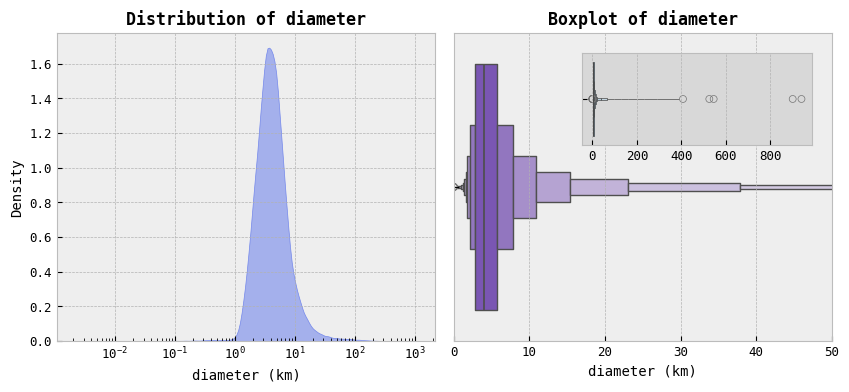

In [7]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='diameter (km)', title='Distribution of diameter')
sns.kdeplot(data=asteroid, x='diameter',fill=True, log_scale=True,  color='#7387EB', alpha=.6)

plt.subplot(122, title='Boxplot of diameter', xlim=(0,50))
sns.boxenplot(data=asteroid, x='diameter',color='#7647C2')
plt.gca().set(xlabel='diameter (km)')

fig.add_axes([0.65,0.6,0.23,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='diameter', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')


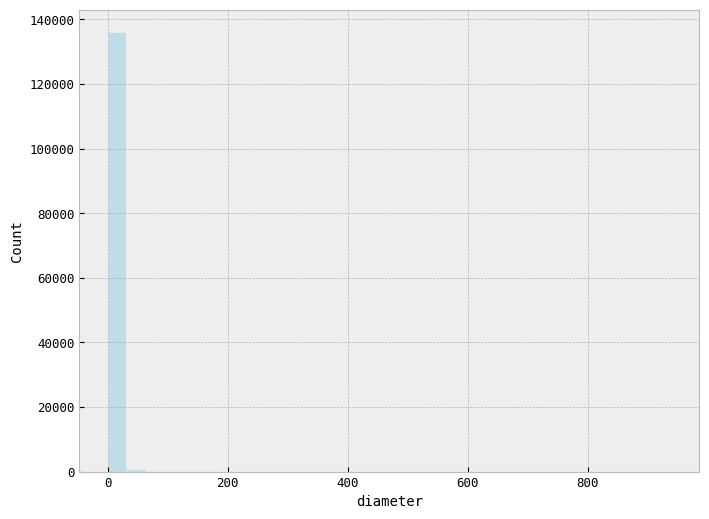

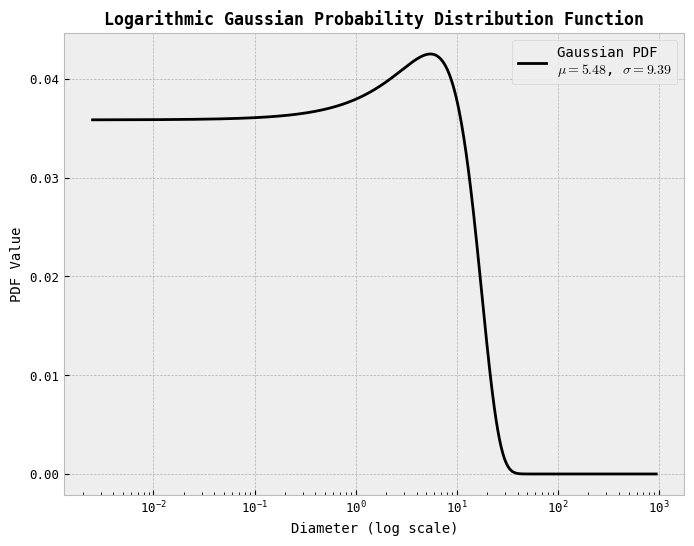

In [8]:
## edited 
diameter_data = asteroid['diameter'].dropna()
mu, std = norm.fit(diameter_data)

plt.figure(figsize=(8, 6))
#Plot the histogram of the data
sns.histplot(diameter_data, bins=30, kde=False, color='lightblue', label='Data Histogram')
plt.savefig('dia_hist.png')

plt.figure(figsize=(8, 6))
# Plot the Gaussian PDF using Matplotlib with a logarithmic x-axis
x_log = np.logspace(np.log10(diameter_data.min()), np.log10(diameter_data.max()), 1000)
p_log = norm.pdf(x_log, mu, std)
plt.plot(x_log, p_log, 'k', linewidth=2, label=f'Gaussian PDF\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')

plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Logarithmic Gaussian Probability Distribution Function')
plt.xlabel('Diameter (log scale)')
plt.ylabel('PDF Value')
plt.savefig('dia_gauss.png')
plt.legend()
plt.show()

Alright, we see that the dataset contains values from 0.0025 to 939, with the most of the values being in a range from 1 to 10. Even though some asteroids seem to be huge and have really large diameters of 800 km or more, the median diameter for the asteroids from this dataset is around 4 km. 

Note, it's wrong to think that the greater the diameter of the asteroid, the more dangerous it is for Earth. The asteroid is considered potentially hazardous only if it is a Near-Earth object, and generally largest asteroids are less common among NEAs, because they have a greater gravitational attraction to the Sun, which causes them to be more stable in their orbits farther from Earth. Additionally, larger asteroids are more rare overall, as they represent a smaller fraction of the total population of asteroids in our solar system. We'll adress this question further on, once we explore `neo` and `pha`.

### Feature: `neo` and `pha`

The two most noteworthy classifications for asteroids are "Near Earth Asteroid" (NEA) or "Near Earth Object" (NEO) and "Potentially Hazardous Asteroid" (PHA). Despite the names, neither classification indicates any direct danger to Earth.

* __Near Earth Asteroids (NEO)__: asteroids with perihelion distance (`q`) less than 1.3 au. NEAs are divided into groups (Atira, Aten, Apollo, Amor) according to their perihelion distance (`q`), aphelion distance (`ad`) and their semi-major axes (`a`).

<!-- ![types of neas](https://cneos.jpl.nasa.gov/images/neo_orbit_types.jpg =800x600) -->
<img src="https://cneos.jpl.nasa.gov/images/neo_orbit_types.jpg" width="800" height="600" />

* __Potentially Hazardous Asteroids (PHA)__: NEAs whose orbits passes within 0.05 au of Earth's (Earth Minimum Orbit Intersection Distance `moid` < 0.05 au) and whose absolute magnitude `H` is 22.0 or brighter (less). PHAs are defined based on parameters that measure asteroid's potential to make threatening close approaches to the Earth. Specifically, asteroids that can't get any closer to the Earth (i.e. `moid`) than 0.05 au or are smaller than 140 m in diameter (i.e. `H`=22.0 with assumed `albedo` of 14%) are not considered PHAs.

In [9]:
asteroid['neo'].isnull().sum(), asteroid['pha'].isnull().sum()

(0, 0)

C:\Users\lrdvi\AppData\Local\Temp\ipykernel_58484\939752118.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=asteroid['pha'], palette=['#ae759f', '#372549'])
C:\Users\lrdvi\AppData\Local\Temp\ipykernel_58484\939752118.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=asteroid['neo'], palette=['#82c0cc', '#005f73'])


[Text(0, 0.5, ' ')]

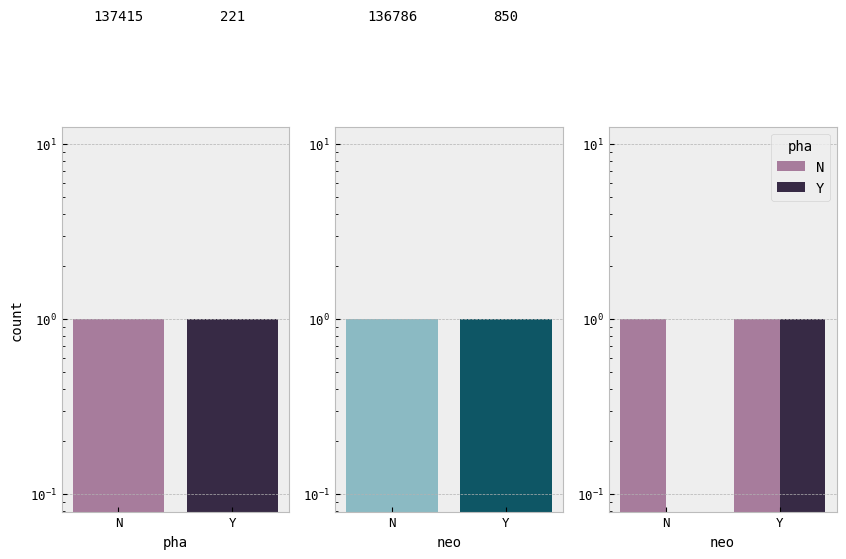

In [10]:
def add_barlabel(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 50, label, ha='center')

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(131, yscale='log')
ax = sns.countplot(x=asteroid['pha'], palette=['#ae759f', '#372549'])
add_barlabel(ax.patches, asteroid['pha'].value_counts().values)

plt.subplot(132, yscale='log')
ax = sns.countplot(x=asteroid['neo'], palette=['#82c0cc', '#005f73'])
ax.set(ylabel=' ')
add_barlabel(ax.patches, asteroid['neo'].value_counts().values)

plt.subplot(133, yscale='log')
ax = sns.countplot(x=asteroid['neo'], hue=asteroid['pha'], palette=['#ae759f', '#372549'])
ax.set(ylabel=' ')

The plots show us there are far more non-dangerous asteroids than these that may be threatening, and even though there are 850 NEA's, only a small fraction of them is considered potentially hazardous.

## Selecting the neccesary features

['data_arc', 'H', 'diameter', 'GM']

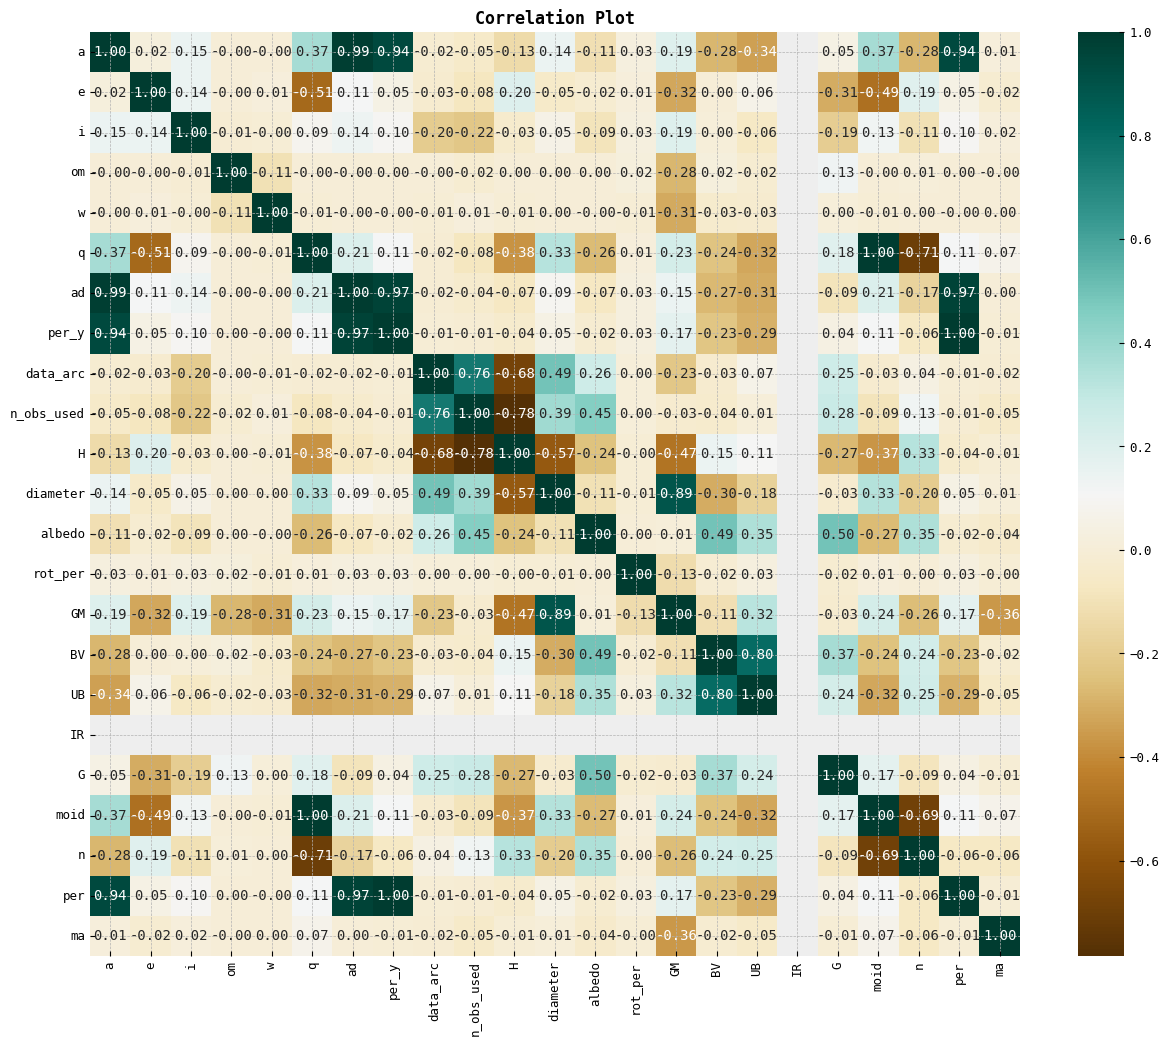

In [11]:
plt.figure(figsize=(15,12))
numeric_asteroid = asteroid.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_asteroid.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', fmt='.2f',)
plt.title('Correlation Plot')
plt.savefig('plot_corr_I.png')
correlation_threshold = 0.4  # Adjust as needed
highly_correlated_features = correlation_matrix['diameter'][abs(correlation_matrix['diameter']) > correlation_threshold].index.tolist()
highly_correlated_features

### Feature: `class`

In [12]:
asteroid['class'].isnull().sum()

0

The following table represents the classes of asteroids as defined by [NASA PDS](https://pdssbn.astro.umd.edu/data_other/objclass.shtml). It includes only classes relevant to our dataset, but feel free to explore more of them.

In [13]:
pd.set_option('display.max_colwidth', None)

dic = {
    'MBA': ['Main-belt Asteroid',
            'Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.',
            '2.0 au < a < 3.2 au;  q > 1.666 au'],
    'OMB': ['Outer Main-belt Asteroid',
            'Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.',
            '3.2 au < a < 4.6 au'],
    'TJN': ['Jupiter Trojan',
            "Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.",
            '4.6 au < a < 5.5 au, e < 0.3'],
    'IMB': ['Inner Main-belt Asteroid',
            "Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt. ",
            'a < 2.0 au; q > 1.666 au'],
    'APO': ['Apollo',
            'Near-Earth asteroids whose orbit crosses the orbit of Earth.',
            'a > 1.0 au; q < 1.017 au'],
    'MCA': ['Mars-crossing Asteroids',
            'Objects with an orbit that crosses the orbit of Mars.',
            '1.3 au < q < 1.666 au; a < 3.2 au'],
    'AMO': ['Amor',
            'Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it',
            'a > 1.0 au; 1.017 au < q < 1.3 au'],
    'ATE': ['Aten',
            'Near-Earth asteroids whose orbit could bring it in close proximity to Earth. ',
            'a < 1.0 au; ad > 0.983 au'],
    'CEN': ['Centaur',
            'Objects with an orbit between Jupiter and Neptune.',
            '5.5 au < a < 30.1 au'],
    'TNO': ['Trans-Neptunian Object',
            'Objects with orbits outside Neptune.',
            'a > 30.1 au'],
    'AST': ['Asteroid (other)',
            'Asteroid orbit not matching any defined orbit class.',
            ' ']  
}

asteroid_classes = pd.DataFrame.from_dict(dic, columns=['Name','Description', 'Details'], orient='index')
asteroid_classes

Name  \
MBA        Main-belt Asteroid   
OMB  Outer Main-belt Asteroid   
TJN            Jupiter Trojan   
IMB  Inner Main-belt Asteroid   
APO                    Apollo   
MCA   Mars-crossing Asteroids   
AMO                      Amor   
ATE                      Aten   
CEN                   Centaur   
TNO    Trans-Neptunian Object   
AST          Asteroid (other)   

                                                                                      Description  \
MBA           Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.   
OMB     Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.   
TJN  Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.   
IMB     Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt.    
APO                                  Near-Earth asteroids whose orbit crosses the orbit of Earth.   
MCA                                         Objects with an orbit that crosses the orbit of Mars.   
AMO          Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it   
ATE                 Near-Earth asteroids whose orbit could bring it in close proximity to Earth.    
CEN                                            Objects with an orbit between Jupiter and Neptune.   
TNO                                                          Objects with orbits outside Neptune.   
AST                                          Asteroid orbit not matching any defined orbit class.   

                                Details  
MBA  2.0 au < a < 3.2 au;  q > 1.666 au  
OMB                 3.2 au < a < 4.6 au  
TJN        4.6 au < a < 5.5 au, e < 0.3  
IMB            a < 2.0 au; q > 1.666 au  
APO            a > 1.0 au; q < 1.017 au  
MCA   1.3 au < q < 1.666 au; a < 3.2 au  
AMO   a > 1.0 au; 1.017 au < q < 1.3 au  
ATE           a < 1.0 au; ad > 0.983 au  
CEN                5.5 au < a < 30.1 au  
TNO                         a > 30.1 au  
AST

In [14]:
### Analysis the features individually

### Feature: `name`

Originally the first asteroids were given mythological names. For example, the __Jupiter trojans__ (asteroids that share the planet Jupiter's orbit around the Sun) are named for characters of the Trojan War, other types of asteroids are given names after Greek characters, Olympic athletes etc. 

In recent years, an overwhelming number of asteroids has been discovered, and new rules have been made. When the asteroid is observed for the first time, it is given a provisional name based on the date it was discovered according to such pattern `(catalog number) Provisional designation`, f.e. (388188) 2006 DP14. Another syntax is also used for confirmed asteroids which is `(catalog number) Name`, where the discoverer chooses the 'Name' to be approved by the International Astronomical Union, say 5535 Annefrank or 274301 Wikipedia.

Theoretically, the diameter of the asteroid does not depend on the name it was given, so we might as well drop this column.

In [15]:
# Some of the names given to asteroids in our dataset (without catalog numbers)
asteroid.name.unique()[10000:]

array(['Buncher', 'Davidharvey', 'Borel', ..., 'Hansklausreif',
       'Gustavomuler', 'Khalat'], dtype=object)

In [16]:
asteroid = asteroid.drop(['name'], axis=1)

### __Feature: `a`__

Kepler stated in the 1st of his laws of planetary motion that each planet moves along an _elliptical_ path with the Sun at one focus of the ellipse. The ellipses are also used to describe the orbits of minor planets which are asteroids.

![ellipse](https://www.astronomynotes.com/history/ellipse.gif)

The planetary orbits are described by the equation of the ellipse, where $a$ - semi-major axis and $b$ - semi-minor axis:

$x^2/a^2 + y^2/b^2 = 1$


The semi-major axis of an asteroid is a measure of the size of its orbit around the Sun, and it determines the asteroid's orbital period and distance from the Sun. To be precise, it is defined as half the length of the longest axis of the ellipse that describes the asteroid's orbit around the Sun. In general, asteroids with larger semi-major axes have longer orbital periods and are located farther from the Sun, such as TNOs and CENs, and may spend a larger portion of their orbit in the outer regions of the solar system. These asteroids may also have longer orbital periods, which can range from a few years to several decades or even centuries.

In [17]:
asteroid.a.isnull().sum()

0

It seems there is no null rows in semi-major axis. Thus the column doesn't contain any null values to remove.

Text(0.5, 0, '')

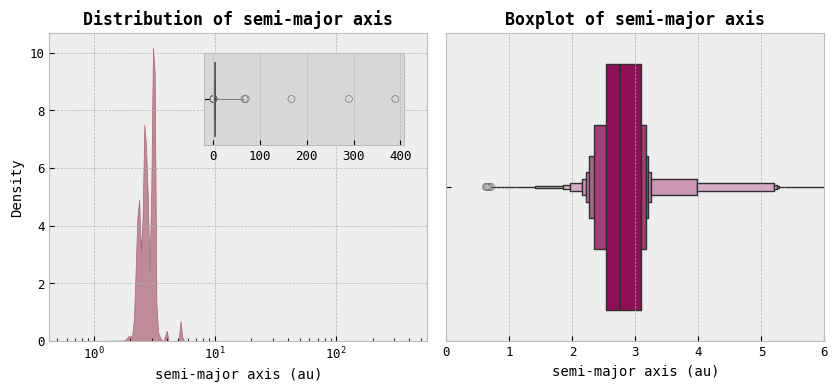

In [18]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='semi-major axis (au)', title='Distribution of semi-major axis')
sns.kdeplot(data=asteroid, x='a',fill=True, log_scale=True,  color='#aa6373', alpha=.7)

plt.subplot(122, title='Boxplot of semi-major axis', xlim=(0,6))
sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#9e0059')
plt.gca().set(xlabel='semi-major axis (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

So we see that the most popular value for semi-major axis is around 3, and, overall, it ranges between 0 au and 5.5 au, depending on the class of the asteroid. For TNOs and CENs, the semi-major axis is much greater than 5.5 au., and we see that there are some asteroids with large semi-major axes, which, I assume, are TNOs.

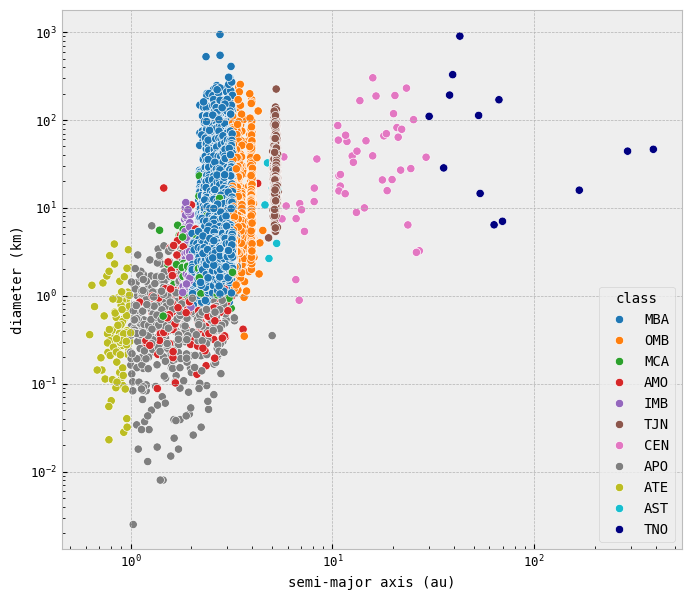

In [19]:
fig, ax = plt.subplots(figsize=(8,7))

# Plot the scatter plot
sns.scatterplot(data=asteroid, x='a', y='diameter', hue='class', palette=classes_palette, ax=ax)
ax.set(xlabel='semi-major axis (au)', ylabel='diameter (km)', xscale='log', yscale='log')
plt.show()

Here indeed we see that the class of an asteroid is defined by the semi-major axis values it can take. If we were to take a look at the table below, which I earlier created to describe the types of classes there are, we see in the details column some constraints on a (semi-major axis) and q (perhelion distance) or ad (aphelion distance). 

Using the upper plot, we could try and check whether the asteroid classes are in compliance with the constraints from the table and see that our data agrees with it.

To sum up, while there may be some correlation between the size of an asteroid and its semi-major axis due to the way that asteroids form and evolve over time, there is not a direct dependence between these properties. Still, it's a really useful feature.

### Feature: `e`

In the context of asteroid orbits, eccentricity is a measure of how elongated an asteroid's orbit is compared to a perfect circle. An asteroid's orbit is an ellipse, which is a shape that looks like a stretched-out circle. The eccentricity of an asteroid's orbit is defined as the ratio of the distance between the foci of the ellipse (the two points that determine the shape of the ellipse) to the length of the major axis of the ellipse (the longest diameter of the ellipse).

An asteroid with an eccentricity of 0 has a perfectly circular orbit, while an asteroid with an eccentricity of 1 has a highly elongated, or "parabolic," orbit. __Most asteroids in our solar system have eccentricities between 0 and 1, with values typically ranging from about 0.1 to 0.5.__

The eccentricity of an asteroid's orbit can have important implications for its behavior and evolution. For example, asteroids with highly eccentric orbits may experience large variations in temperature as they move closer to and farther away from the Sun, which can affect their physical properties and potential for activity. Additionally, asteroids with high eccentricities may be more likely to experience close encounters with other celestial bodies, which can perturb their orbits and potentially lead to collisions.

So, the eccentricity of an asteroid's orbit can have an __indirect impact__ on its size, and thus diameter, particularly if the asteroid's orbit brings it close to other celestial bodies such as the Sun or planets. If an asteroid has a highly eccentric orbit that brings it close to the Sun, it may experience heating and other physical processes that can alter its size, shape, and composition. Similarly, if an asteroid's orbit brings it close to a planet, it may be subject to gravitational perturbations that can alter its trajectory and potentially cause collisions with other asteroids or planets.

In [20]:
asteroid.e.isnull().sum()

0

[Text(0.5, 0, 'eccentricity')]

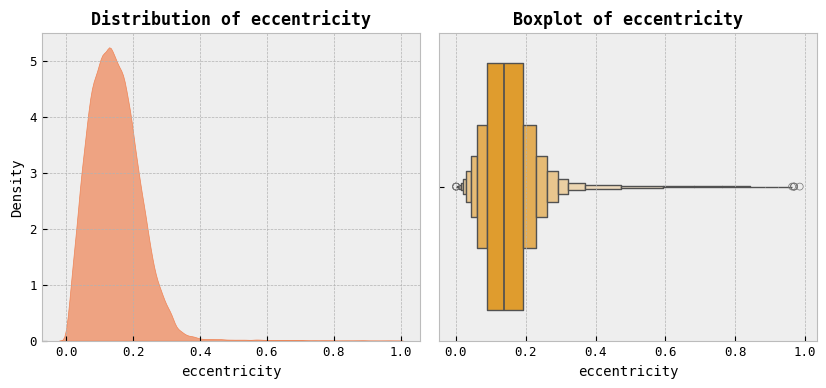

In [21]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='eccentricity', title='Distribution of eccentricity')
sns.kdeplot(data=asteroid, x='e',fill=True,  color='#ef8354', alpha=.7, )

plt.subplot(122, title='Boxplot of eccentricity')
sns.boxenplot(data=asteroid, x='e',color='#fca311')
plt.gca().set(xlabel='eccentricity',)

The eccentricity ranges from 0.0 to 0.3, which says that most asteroids have slightly elongated orbit.

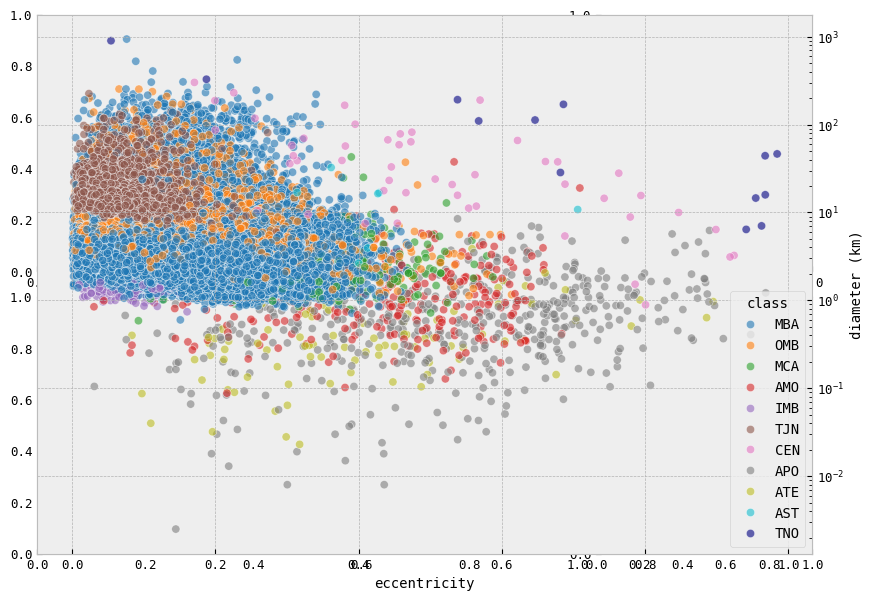

In [22]:
fig,ax = plt.subplots(2,2, figsize=(10,7), gridspec_kw={'width_ratios': [2.5,1]}, )
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(1,1,(1,1), xlabel='eccentricity', ylabel='diameter (km)', yscale='log')
sns.scatterplot(data=asteroid, x='e', y='diameter', hue='class', palette=classes_palette, alpha=.6)

plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

In [23]:
asteroid[['e','class']].groupby(['class']).median().T

class      AMO       APO       AST       ATE       CEN       IMB       MBA  \
e      0.45487  0.543582  0.412453  0.373596  0.465996  0.082805  0.140421   

class       MCA       OMB      TJN       TNO  
e      0.322762  0.120815  0.07046  0.685937

#### Takeaways

#### NEAs (APOs, ATEs and AMOs)

First thing to note, the eccentricity of the NEAs is usually higher than that of asteroids that are not NEAs (every class except for APO, ATE, AMO). To be clear, the plot shows that the eccentricity of NEAs is almost 0.5 and of other asteroids 0.13.

There may be a few reasons for that. One, NEAs generally originate from the main asteroid belt between Mars and Jupiter, but their orbits have been perturbed by gravitational interactions with the planets, especially Jupiter. These perturbations can cause their orbits to become more eccentric over time. Second, NEAs are also subject to the gravitational influence of the Earth and the Moon, which can cause their orbits to become more elliptical as they approach our planet. This is especially true for Earth-crossing asteroids, like APOs, AMOs, ATEs (and we see in the large plot that a lot of the asteroids of these classes indeed have high eccentricities). The other reason could be that the orbits of NEAs are also affected by the Yarkovsky effect, a subtle force caused by the heating and cooling of the asteroid's surface by sunlight. This effect can cause an asteroid's orbit to become more eccentric over time.

But overall, all of these effects can lead to high eccentricities, and this is crucial, because  __NEAs with highly eccentric orbits are more likely to cross the Earth's orbit, and therefore have a greater potential to impact our planet, so it becomes really important to measure the diameter of such asteroids correctly.__

#### IMBS, MBAs, OMBs

These asteroids are located in the main asteroid belt, which is a region of space located between the orbits of Mars and Jupiter. And they usually have low-eccentricity orbits due to Jupiter's gravitational influence. Because Jupiter's orbit is located near the main asteroid belt, its gravity affects the orbits of the asteroids in this region. Jupiter's gravity creates a phenomenon known as orbital resonance, which causes some asteroids to have stable, low-eccentricity orbits.

For example, in the case of MBAs, Jupiter's gravity pulls them into a specific resonant configuration, which creates a stable orbital zone that is not significantly disturbed by Jupiter's gravity or other objects in the Solar System. This resonance effectively locks the MBAs into stable, low-eccentricity orbits. The same is true for OMBs and IMBs, which are located in different regions of the main asteroid belt.

#### MCAs

As for other classes of asteroids, we see that asteroids with orbits near the asteroid belt usually have low eccentricities of 0.12 on average. The MCAs might have higher eccentricities due to gravitational perturbations from Mars, or MCAs may also have originated from farther out in the asteroid belt, where the gravitational influence of Jupiter is stronger, and this can result in more chaotic and eccentric orbits, which can lead to MCAs crossing the orbit of Mars.

#### CENs, TNOs

In general, as an asteroid moves farther away from the Sun, it is more likely to encounter the gravitational pull of outer planets like Jupiter or Saturn. These encounters can cause the asteroid's orbit to become more elongated, resulting in a higher eccentricity. Moreover, asteroids that formed farther from the Sun may have had more chaotic environments, which could have resulted in more eccentric orbits. So, the combination of these factors can lead to higher eccentricities for asteroids that are farther from the Sun. Still, TNOs are generally far enough away from other large objects that they are not strongly affected by their gravity. As a result, they may have relatively stable and circular orbits with low eccentricities sometimes. 

However, on average, both CENs and TNOs tend to have higher eccentricities compared to other asteroid populations, such as MBAs, OMBs, and IMBs.

#### TJNs

On the other hand, TJNs, though being far away, have relatively stable orbits and low levels of eccentricity.The stability of the Jupiter Trojans' orbits is due to the gravitational influence of both Jupiter and the Sun. Jupiter's gravitational pull keeps the Trojans in their stable orbits around the L4 and L5 Lagrange points, while the Sun's gravity provides a balancing force that helps to stabilize the orbits over long periods of time. 

The combination of Jupiter's and the Sun's gravitational influence creates a region of space known as the "Jupiter Trojans swarm", where the gravitational forces are in equilibrium and result in a stable region for these asteroids to orbit. In addition, Jupiter Trojans may be less susceptible to the Yarkovsky effect, a subtle force that can cause asteroids to drift over time due to the heating and cooling of their surfaces by sunlight. This is because the Trojans are relatively large (they have huge diameters) and have slower orbital speeds, which means that they are less likely to be influenced by this effect than smaller asteroids with faster orbits.

### Feature: `i`

In the context of asteroids, inclination refers to the angle between the asteroid's orbital plane and the plane of reference for the Solar System, which is defined as the plane of the ecliptic. The inclination is measured in degrees and can range from 0° to 180°.

The plane of the ecliptic is the flat disk-like structure that contains the orbits of the planets in our Solar System, including Earth. Most asteroids have orbits that are tilted with respect to this plane, which means that they have non-zero inclinations.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/800px-Orbit1.svg.png" width="400" height="700" />

For example, an asteroid with a high inclination may have an orbit that takes it far above or below the plane of the Solar System, which could make it less likely to interact with other objects in the Solar System. On the other hand, an asteroid with a low inclination may have an orbit that intersects with the plane of the Solar System, making it more likely to interact with other objects, including planets.

In [24]:
asteroid.i.isnull().sum()

0

<Axes: xlabel='inclination (deg)', ylabel='semi-major axis (au)'>

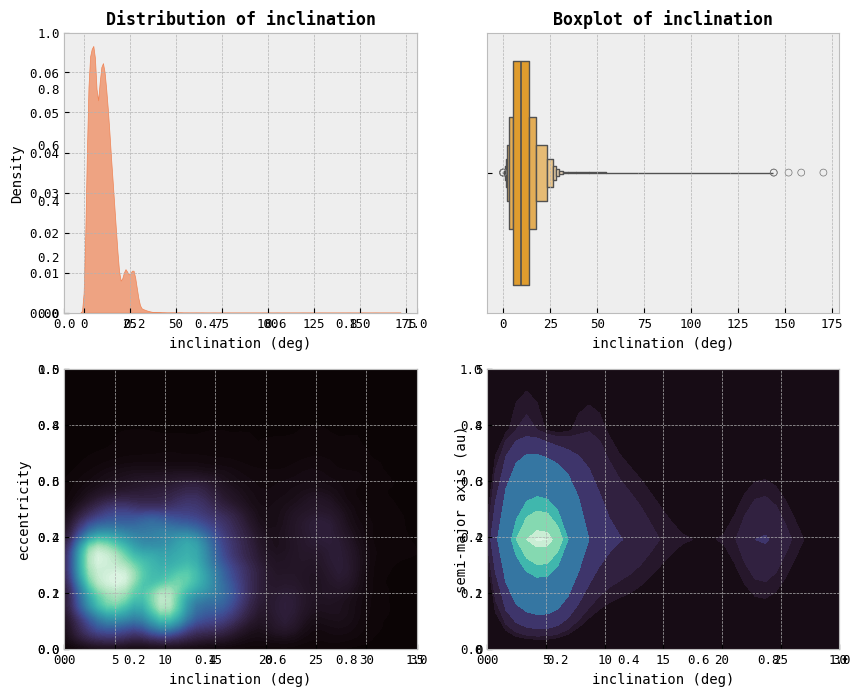

In [25]:
fig = plt.subplots(2,2,figsize=(10,8))
# plt.subplots_adjust(space=0.05, )

plt.subplot(221, xlabel='inclination (deg)', title='Distribution of inclination')
sns.kdeplot(data=asteroid, x='i',fill=True,  color='#ef8354', alpha=.7, )

plt.subplot(222)
sns.boxenplot(data=asteroid, x='i',color='#fca311')
plt.gca().set(xlabel='inclination (deg)', title='Boxplot of inclination')

plt.subplot(223, xlabel='inclination (deg)', ylabel='eccentricity', xlim=(0,35), ylim=(0,0.5))
sns.kdeplot(asteroid, x='i', y='e', fill=True, thresh=0, levels=100, cmap='mako')

plt.subplot(224, xlabel='inclination (deg)', ylabel='semi-major axis (au)', xlim=(0,30), ylim=(0,5))
sns.kdeplot(asteroid, x='i', y='a', fill=True, levels=10,thresh=0, cmap='mako')

So we see that most of the eccentricities are from 0 deg to 25 deg. On the lower left plot we see that the majority of asteroids have either eccentricities from 0.05 to 0.2 and inclinations from around 2 deg to 7 deg, or eccentricitties lower than 0.15 and inclinations somewhere around 10 deg. This may be a hint telling us that most of the asteroids in our dataset are MBAs (low eccentricity due to stable orbit). Not to mention that for these values of inclination we have the range for semi-major axis from 0.5 au to 3.5 au. Such semi-major axes commonly have MBAs, OMBs, IMBs, APOs, MCAs, AMOs, ATEs.

Therefore, the relationship between an asteroid's inclination and eccentricity can provide important information about the class asteroid belongs to, and thus, its overall characteristics.

From the plots this can be concluded:

* MBAs typically have low eccentricities and inclinations, which means their orbits are relatively stable.
* MCAs usually have low-inclination but high-eccentricity orbits, because they may have been perturbed by the gravity of Mars.
* NEAs have orbits that bring them close to or cross the orbit of Earth. As a result, they tend to have higher eccentricities and inclinations than MBAs.Certain types of NEAs such as ATEs tend to have higher inclinations than other.
* TJNs are located in stable regions around the Lagrange points of Jupiter's orbit, and they typically have low eccentricities and inclinations. 
* CENs are objects that orbit the Sun between Jupiter and Neptune, and they typically have high inclinations and eccentricities, since many CENs are believed to have originated in the Kuiper Belt. It suggests that they may have been gravitationally scattered by Neptune or other large planets.
* TNOs have a wide range of eccentricities and inclinations. Some TNOs have highly elliptical and inclined orbits for the same reasons CENs have too.

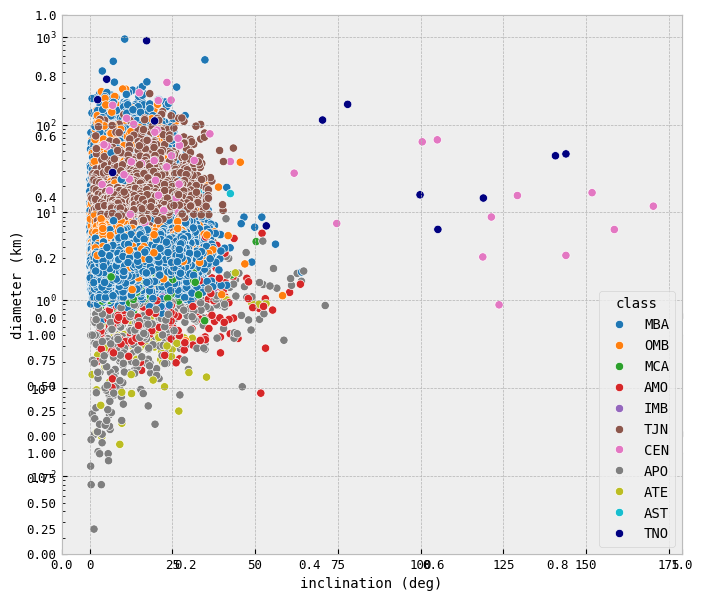

In [26]:
fig, ax = plt.subplots(3,1, figsize=(8,7), gridspec_kw={'height_ratios': [3,1,1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)

plt.subplot(111)
sns.scatterplot(data=asteroid, x='i', y='diameter', hue='class', palette=classes_palette)
plt.gca().set(ylabel='diameter (km)', yscale='log')

plt.xlabel('inclination (deg)')
plt.show()

The relationship between an asteroid's inclination and diameter is not as clear-cut as its relationship with eccentricity. Generally, some classes of asteroids may have a tendency towards certain inclinations or size ranges, but there is no straightforward relation between the two.

### Feature: `om`

Longitude of the Ascending Node (LAN) is a parameter that specifies the position of an object's orbital ascending node, which is the point at which its orbit intersects the plane of reference (usually the ecliptic). The LAN is measured in degrees eastward along the ecliptic from a reference direction, which is typically defined as the point where the ecliptic intersects the celestial equator at the vernal equinox.

It represents the point in the sky where the asteroid's orbit intersects the plane of the ecliptic as it moves northward across the plane.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/800px-Orbit1.svg.png" width="400" height="700" />

In [27]:
asteroid.om.isnull().sum()

0

Text(0.5, 0, 'LAN (deg)')

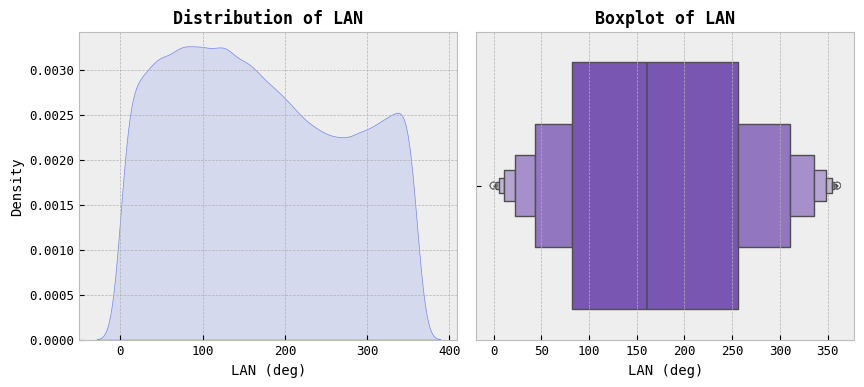

In [28]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='LAN (deg)', title='Distribution of LAN')
sns.kdeplot(data=asteroid, x='om',fill=True, color='#7387EB', alpha=.2)

plt.subplot(122, title='Boxplot of LAN',)
sns.boxenplot(data=asteroid, x='om',color='#7647C2')
plt.xlabel('LAN (deg)')

We see that LAN spans all degrees, and the most common value for the asteroids is 160 deg.

[None, Text(0.5, 0, 'LAN (deg)'), Text(0, 0.5, 'diameter (km)')]

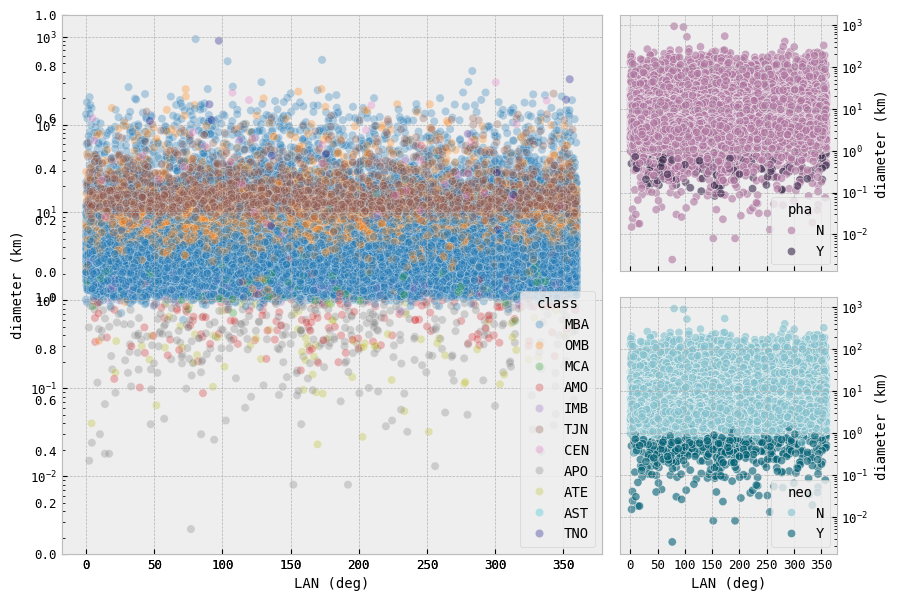

In [29]:
fig,ax = plt.subplots(2,2, figsize=(10,7), gridspec_kw={'width_ratios': [2.5,1]}, sharex=True)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2,2,(1,3), xlabel='LAN (deg)', ylabel='diameter (km)', yscale='log')
sns.scatterplot(data=asteroid, x='om', y='diameter', hue='class', palette=classes_palette, alpha=.3)

sns.scatterplot(data=asteroid, x='om', y='diameter', hue='pha', alpha=.6,
                palette=['#ae759f', '#372549'], ax=ax[1])
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set(yscale='log', xlabel='LAN (deg)', ylabel='diameter (km)')

sns.scatterplot(data=asteroid, x='om', y='diameter', hue='neo', alpha=.6, 
                palette=['#82c0cc', '#005f73'], ax=ax[3])
ax[3].yaxis.tick_right()
ax[3].yaxis.set_label_position("right")
ax[3].set(yscale='log', xlabel='LAN (deg)', ylabel='diameter (km)')

Overall, while there is no simple relationship between asteroid size and LAN or between orbital parameters such as LAN and inclination.

### Feature: `w`

The argument of perihelion is an orbital parameter that describes the orientation of an asteroid's orbit with respect to the position of the Sun at perihelion, which is the point in its orbit where it is closest to the Sun. Specifically, the argument of perihelion is the angle between the asteroid's periapsis (closest point to the Sun) and its ascending node (the point where it crosses the ecliptic plane from south to north), as measured in the plane of the asteroid's orbit.

In other words, the argument of perihelion specifies the direction in which the asteroid's orbit is tilted relative to the ecliptic plane (the plane of Earth's orbit around the Sun) at the point of closest approach to the Sun.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/800px-Orbit1.svg.png" width="400" height="700" />

This can have important implications for the asteroid's behavior and interactions with other bodies in the solar system, as well as its potential for impact with Earth.

In [30]:
asteroid.w.isnull().sum()

0

We see that the argument of perihelion spans all possible values, with the median of 184 (deg).

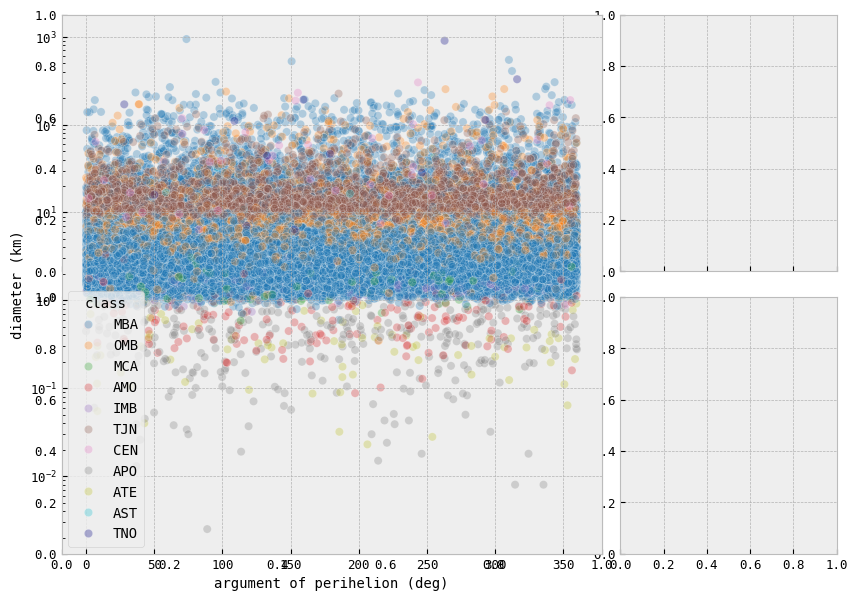

In [31]:
fig,ax = plt.subplots(2,2, figsize=(10,7), gridspec_kw={'width_ratios': [2.5,1]}, sharex=True)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2,2,(1,3), xlabel='argument of perihelion (deg)', ylabel='diameter (km)', yscale='log')
sns.scatterplot(data=asteroid, x='w', y='diameter', hue='class', palette=classes_palette, alpha=.3)
plt.show()

All groups seem to have more varied argument of perihelion values, reflecting the diversity of orbits in the populations.

### Feature: `q`

The perihelion distance is an orbital parameter that describes the closest distance between an asteroid and the Sun during its orbit around the Sun. Specifically, perihelion distance is the point in the asteroid's orbit where it is closest to the Sun.

<img src="https://df0b18phdhzpx.cloudfront.net/ckeditor_assets/pictures/1640917/original_Picture5.png" width="500" height="700" />

At perihelion, the asteroid is closest to the Sun and therefore receives the highest amount of solar radiation, which can cause its surface to heat up and possibly undergo physical changes such as sublimation of volatile materials.

In [32]:
asteroid.q.isnull().sum()

0

Text(0.5, 0, '')

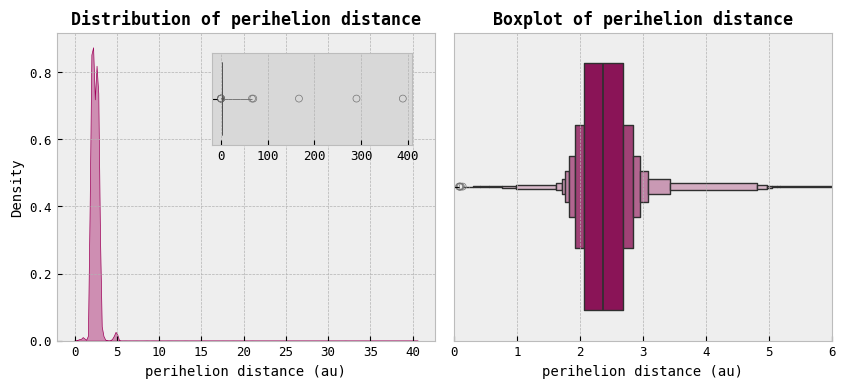

In [33]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='perihelion distance (au)', title='Distribution of perihelion distance')
sns.kdeplot(data=asteroid, x='q',fill=True, color='#9e0059', alpha=.4)

plt.subplot(122, title='Boxplot of perihelion distance', xlim=(0,6))
sns.boxenplot(data=asteroid, x='q',color='#9e0059')
plt.xlabel('perihelion distance (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

The perihelion distance commonly ranges from 0 to 5 for our dataset, with the median of 2.4 (au).

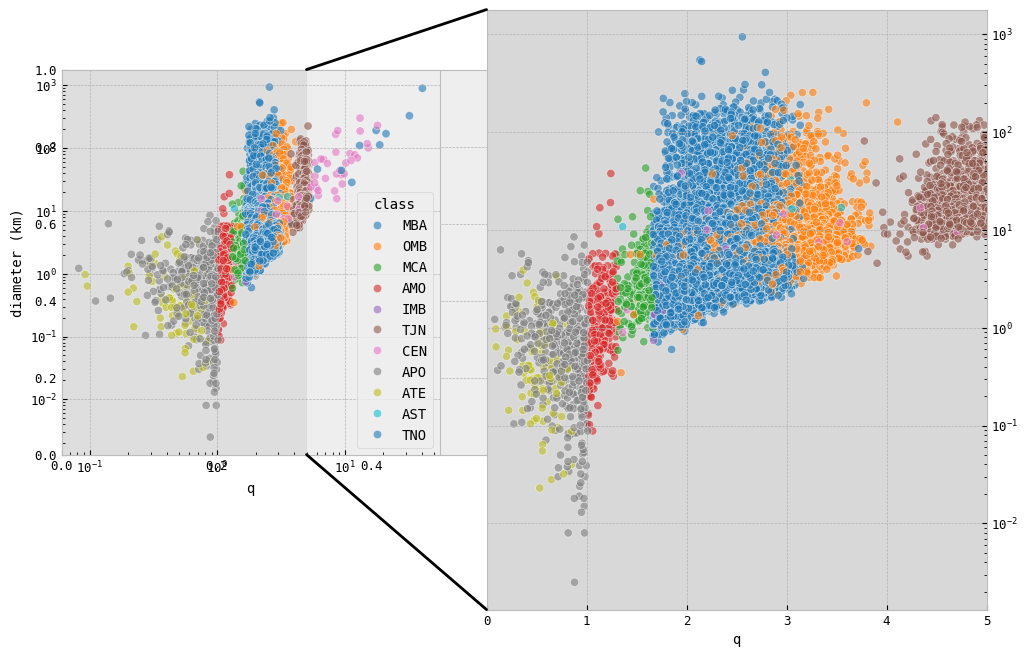

In [34]:
fig,ax = plt.subplots(1,1, figsize=(10,5),)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Add the main plot.
plt.subplot(1,2,1, xlabel='', ylabel='diameter (km)', yscale='log', xscale='log')
plt.axvspan(0, 5, facecolor='#D8D8D8', alpha=0.7)   # Create blocked area
ax = sns.scatterplot(data=asteroid, x='q', y='diameter', hue='class', palette='tab10', alpha=.6)

# Add zoom-in plot.
fig.add_axes([0.55,-0.2,0.5,1.2], xlabel='', ylabel=' ', yscale='log', xlim=(0,5))
sns.scatterplot(data=asteroid, x='q', y='diameter', hue='class', palette='tab10', alpha=.6)
plt.gca().yaxis.tick_right()
plt.gca().set_facecolor('#D8D8D8')
plt.legend().set_visible(False)

min_y, max_y = ax.get_ylim()

# Create left side of Connection patch
con1 = ConnectionPatch(xyA=(5, max_y), coordsA=ax.transData, 
                       xyB=(0, max_y), coordsB=plt.gca().transData, color = 'black', linewidth=2)
fig.add_artist(con1)

# Create right side of Connection patch
con2 = ConnectionPatch(xyA=(5, min_y), coordsA=ax.transData, 
                       xyB=(0, min_y), coordsB=plt.gca().transData, color = 'black', linewidth=2)
fig.add_artist(con2)

The perihelion distance can vary widely among different asteroids and asteroid populations, depending on the size and shape of their orbits. For example, from the plot above we see that MCAs generally have perihelion ranging from 1.3 au to 1.7 au, AMOs from around 1.0 au to 1.3 au and so on. We can see clear clusters of asteroids just by looking at the points in the light of perihelion distance.

And if we plot asteroids' perihelion distance vs. semi-major axis, we'll see the whole beauty of how specific classes are defined based on these parameters, which one can also check in the table below. 

* NEAs generally have perihelion distances that are much closer to the Sun than their semi-major axes, due to their highly eccentric and often Earth-crossing orbits. This means that their perihelion distances can range from less than 0.1 AU to about 1.3 AU, even for asteroids with relatively large semi-major axes.
* The perihelion distance of MBAs generally increases with increasing semi-major axis, forming a curved shape known as the "Main Belt arc." This is because the gravitational influence of Jupiter tends to push asteroids with higher perihelion distances and lower eccentricities toward their aphelion, while asteroids with lower perihelion distances and higher eccentricities tend to be scattered into more eccentric orbits or ejected from the Main Belt altogether.
* IMBs have semi-major axes between 1.78 and 2.00 AU. Their perihelion distances are typically around 1.8 AU, which is close to the inner edge of the Main Belt arc.
* OMBs are asteroids with semi-major axes between 3.27 and 3.7 AU. Their perihelion distances can range from about 2.7 AU to over 3.2 AU, with a slight tendency for larger perihelion distances at larger semi-major axes.
* The perihelion distances of TJNs can vary depending on whether they are leading or trailing Trojans, but in general they have relatively low eccentricities and perihelion distances close to Jupiter's orbit.
* CENs have highly eccentric and inclined orbits, with perihelion distances ranging from about 5 to 30 AU.
* TNOs can have highly eccentric and inclined orbits that allow them to have perihelion distances that range from close to the Sun to well beyond the orbit of Neptune. There are different groups of TNOs, but we won't discuss it here.

In [35]:
asteroid_classes

Name  \
MBA        Main-belt Asteroid   
OMB  Outer Main-belt Asteroid   
TJN            Jupiter Trojan   
IMB  Inner Main-belt Asteroid   
APO                    Apollo   
MCA   Mars-crossing Asteroids   
AMO                      Amor   
ATE                      Aten   
CEN                   Centaur   
TNO    Trans-Neptunian Object   
AST          Asteroid (other)   

                                                                                      Description  \
MBA           Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.   
OMB     Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.   
TJN  Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.   
IMB     Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt.    
APO                                  Near-Earth asteroids whose orbit crosses the orbit of Earth.   
MCA                                         Objects with an orbit that crosses the orbit of Mars.   
AMO          Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it   
ATE                 Near-Earth asteroids whose orbit could bring it in close proximity to Earth.    
CEN                                            Objects with an orbit between Jupiter and Neptune.   
TNO                                                          Objects with orbits outside Neptune.   
AST                                          Asteroid orbit not matching any defined orbit class.   

                                Details  
MBA  2.0 au < a < 3.2 au;  q > 1.666 au  
OMB                 3.2 au < a < 4.6 au  
TJN        4.6 au < a < 5.5 au, e < 0.3  
IMB            a < 2.0 au; q > 1.666 au  
APO            a > 1.0 au; q < 1.017 au  
MCA   1.3 au < q < 1.666 au; a < 3.2 au  
AMO   a > 1.0 au; 1.017 au < q < 1.3 au  
ATE           a < 1.0 au; ad > 0.983 au  
CEN                5.5 au < a < 30.1 au  
TNO                         a > 30.1 au  
AST

### Feature: `ad`

The aphelion distance of an asteroid is the point in its orbit where it is farthest from the Sun. It is the opposite point of the orbit from the perihelion distance, which is the point where the asteroid is closest to the Sun.

<img src="https://df0b18phdhzpx.cloudfront.net/ckeditor_assets/pictures/1640917/original_Picture5.png" width="500" height="700" />

In [36]:
asteroid.ad.isnull().sum()

0

Text(0.5, 0, '')

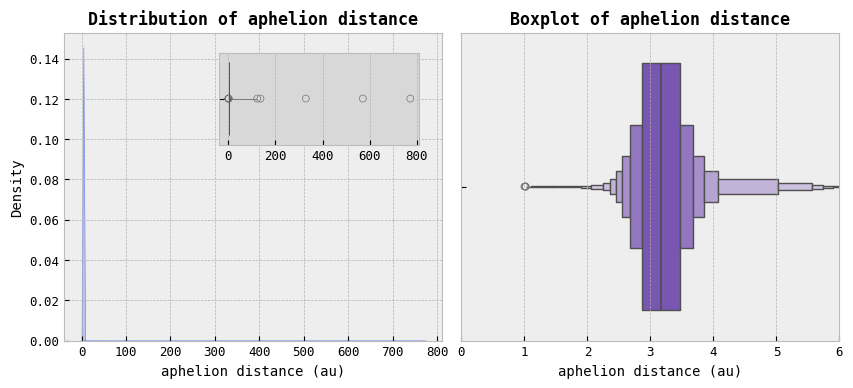

In [37]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='aphelion distance (au)', title='Distribution of aphelion distance')
sns.kdeplot(data=asteroid, x='ad',fill=True, color='#7387EB', alpha=.4)

plt.subplot(122, title='Boxplot of aphelion distance', xlim=(0,6))
sns.boxenplot(data=asteroid, x='ad',color='#7647C2')
plt.xlabel('aphelion distance (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='ad', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

* The relationship between aphelion distance and perihelion distance for asteroids of different classes can vary. However, in general, the greater the eccentricity of an asteroid's orbit, the larger the difference between its aphelion and perihelion distances.
* NEAs: all have highly eccentric orbits, which means that their aphelion distance and perihelion distance can differ significantly. ATEs have orbits entirely inside the Earth's orbit but still close to it, typically have aphelion distances that are not significantly larger than their perihelion distances. For APOs, which have orbits that are mostly inside the Earth's orbit and cross it, the aphelion distance is typically much larger than the perihelion distance. For AMOs, which have orbits that cross Earth's orbit from the outside, the aphelion distance can be significantly larger than the perihelion distance as well.
* IMBs and OMBs have orbits that are less eccentric than those of NEAs and TNOs. Therefore, their aphelion distance and perihelion distance are typically more similar in value.
* MBAs: Their orbits are mostly circular, with eccentricities typically less than 0.3. This means that their aphelion and perihelion distances are relatively close, therefore their orbits should be relatively stable and predictable.
* MCAs have orbits that cross the orbit of Mars, which means that their perihelion distances are closer to the Sun than those of IMBs and OMBs. Their aphelion distances can be significantly larger than their perihelion distances depending on the specific orbit of the asteroid.
* TJNs have orbits that are stabilized by the gravity of Jupiter, which means that their orbits are relatively stable and not highly eccentric. Therefore, their aphelion and perihelion distances are typically not very different from each other.
* CENs and TNOs: They have highly elliptical orbits, with eccentricities greater than 0.3. This leads to them having large differences between aphelion and perihelion distances. Their orbits are rather chaotic and hard to predict due to that.

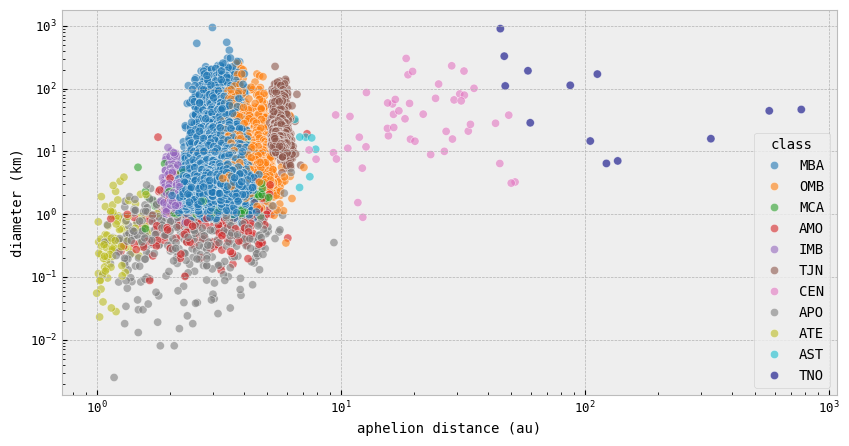

In [38]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=asteroid, x='ad', y='diameter', hue='class', palette=classes_palette, 
                     alpha=.6)
ax.set(xscale='log', yscale='log', xlabel='aphelion distance (au)', ylabel='diameter (km)',);

While the aphelion distance of an asteroid is not directly related to its diameter, the size and mass of an asteroid can have an indirect effect on its orbit and its aphelion distance through gravitational interactions with other celestial bodies. For example, if an asteroid passes close to a planet, the planet's gravitational pull can alter the asteroid's trajectory and affect its orbit.

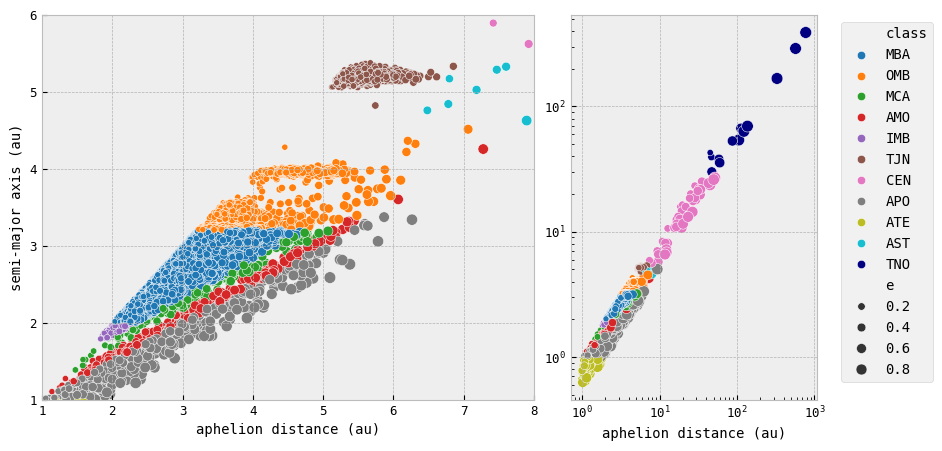

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [2.,1]},)
plt.subplots_adjust(wspace=0.1)

sns.scatterplot(data=asteroid, x='ad', y='a', hue='class', palette=classes_palette, size='e',
               ax=ax[0])
ax[0].set(xlim=(1,8), ylim=(1,6), xlabel='aphelion distance (au)', ylabel='semi-major axis (au)')
ax[0].legend().set_visible(False)

sns.scatterplot(data=asteroid, x='ad', y='a', hue='class', palette=classes_palette, size='e', 
                ax=ax[1])
ax[1].set(xscale='log', yscale='log', ylabel=' ', xlabel='aphelion distance (au)')
sns.move_legend(ax[1], loc='upper right', bbox_to_anchor=(1.5, 1.),)

Since the semi-major axis of an asteroid is the average distance between the asteroid and the sun, it determines the overall shape and size of the asteroid's elliptical orbit. The aphelion distance is the point at which the asteroid is farthest from the sun in its orbit, and this distance is directly related to the semi-major axis of the ellipse. Specifically, the aphelion distance is equal to $a(1+e)$.

In summary, the aphelion distance of an asteroid is related to its semi-major axis through Kepler's laws of planetary motion, specifically through the shape and size of the asteroid's elliptical orbit.

### Features: `per_y` and `per`

The orbital period of an asteroid is the time it takes for the asteroid to complete one orbit around the Sun. The equation is: $T = 2π√(a^3/GM)$
The Time period doesn't provide any new information it will have similar distribution as semimajor axis, with difference in the scale of feature axis.

Both of the features define the same orbital period, but in different units: `per` in days and `per_y` in years.

In [40]:
asteroid.per_y.isnull().sum(), asteroid.per.isnull().sum()

(0, 0)

[Text(0.5, 0, ''), None]

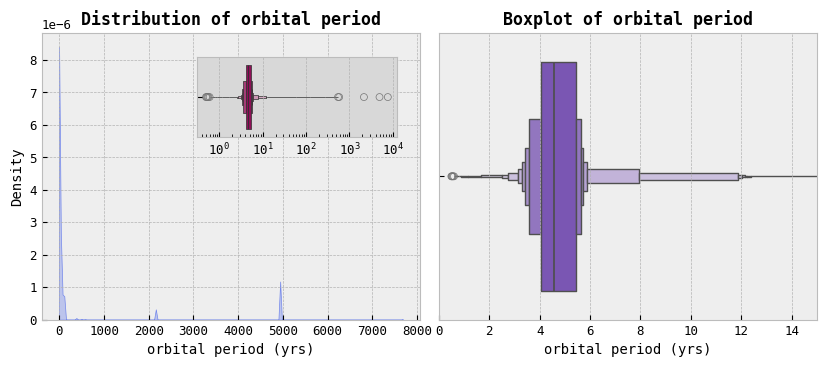

In [41]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# Plots for orbital period in years.
plt.subplot(221, xlabel='orbital period (yrs)', title='Distribution of orbital period', )
sns.kdeplot(data=asteroid, x='per_y',fill=True, color='#7387EB', alpha=.4)

plt.subplot(222, title='Boxplot of orbital period', xlim=(0,15))
sns.boxenplot(data=asteroid, x='per_y',color='#7647C2')
plt.xlabel('orbital period (yrs)')

fig.add_axes([0.28,0.75,0.20,0.10])
zoom_out_ax = sns.boxenplot(data=asteroid, x='per_y', saturation=.8, color='#9e0059', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
zoom_out_ax.set(xlabel='', xscale='log')

We see that the most common value for a period is 4.5 years or around 1666 days.

Since we have two features in the dataset representing orbital period, one in years and the other in days, we may want to consider keeping only one of them. Having both features may introduce redundant information into model and could potentially increase its complexity without adding any additional predictive power.

The unit of measurement for the orbital period for asteroids is usually given in years, since it is a very long timescale for most of them. Thus, we'll drop the one in days.

In [42]:
asteroid.drop(['per'], axis=1, inplace=True)

<Axes: xlabel='orbital period (yrs)', ylabel='semi-major axis (au)'>

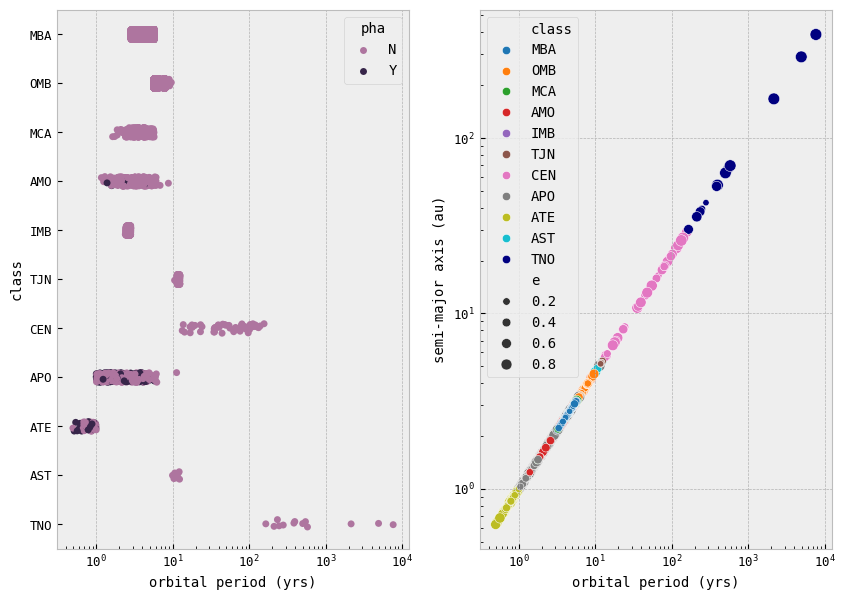

In [43]:
fig, ax = plt.subplots(1,2,figsize=(10,7), gridspec_kw={'width_ratios': [1,1]},)

ax[0].set(xscale='log', xlabel='orbital period (yrs)')
sns.stripplot(asteroid, x='per_y', y='class', hue='pha', ax=ax[0], palette=['#ae759f', '#372549'])

ax[1].set(xscale='log', yscale='log',xlabel='orbital period (yrs)', ylabel='semi-major axis (au)')
sns.scatterplot(asteroid, x='per_y', y='a', hue='class', ax=ax[1], palette=classes_palette, size='e')

The upper right plot shows us that there is certainly some relationship between semi-major axis and orbital period, and we already know one: $T \propto a^{3/2}$.

As for other plots, the following coclusions can be drawn from them:
* NEAs: ATEs orbital periods are typically less than 1 year due to their close proximity to the Sun. However, APOs and AMOs orbital periods range from 1 to 10 years.
* MCAs have orbital periods that range from about 2 to 5 years.
* MBAs have orbital periods that range from about 3 to 6 years.
* OMBs have longer orbital periods than MBAs, ranging from about 6 to 20 years. They also tend to have higher eccentricities and inclinations than MBAs, as we earlier deduced.
* IMBs ave shorter orbital periods than MBAs, ranging from about 2 to 3 years. They tend to have relatively low eccentricities and inclinations.
* TJNs have orbital periods that are similar to Jupiter's, ranging from about 11 to 12 years. They also have low eccentricities and inclinations.
* CENs have orbital periods that range from about 10 to 100 years and have high eccentricities and inclinations.
* TNOs have a wide range of orbital periods, from several decades to thousands of years. They tend to have high eccentricities and inclinations, and their semi-major axes are much larger than those of other asteroid classes.

### Features: `data_arc` and `n_obs_used`

The `data-arc` feature refers to the length of the time interval over which observations of an asteroid have been made, i.e. the data-arc is the time between the first and last observations of an asteroid. The data-arc provides information about the quality and quantity of observations of the asteroid, which can in turn affect the accuracy of predictions about its orbit and future behavior.

For example, an asteroid with a data-arc of only a few days may have uncertain orbital parameters and may be difficult to track accurately over time. On the other hand, an asteroid with a long data-arc spanning many years may have more accurately determined orbital parameters and may be more predictable over longer time periods.

The `n_obs_used` refers to the total number of observations of an asteroid that were used to compute its orbital parameters. In general, more observations lead to a more accurate orbit, but there are diminishing returns beyond a certain number of observations (while more observations generally lead to a more accurate fitted orbit, there comes a point where the improvement in accuracy is no longer significant, and additional observations may not be worth the effort or computational resources required to process them). 

Additionally, observations made over a longer period of time (i.e. with a longer data-arc) may provide more accurate orbital parameters than observations made over a shorter period of time.

In [44]:
asteroid.data_arc.isnull().sum(), asteroid.n_obs_used.isnull().sum()

(138, 0)

We see that `data_arc` feature has 138 null values. Instead of removing these rows without data arc span, we would just fill the gaps with the median data arc span.

In [45]:
asteroid['data_arc'].fillna(asteroid['data_arc'].median(), inplace=True)

Text(0.5, 0, 'data arc span(d)')

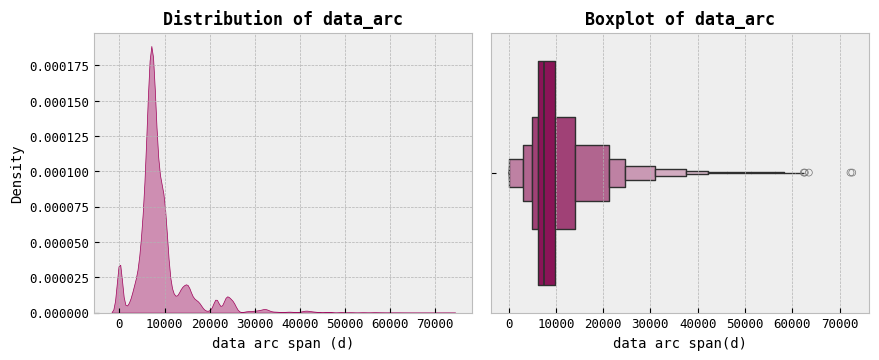

In [46]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='data arc span (d)', title='Distribution of data_arc', )
sns.kdeplot(data=asteroid, x='data_arc',fill=True, color='#9e0059', alpha=.4)

plt.subplot(222, title='Boxplot of data_arc', )
sns.boxenplot(data=asteroid, x='data_arc',color='#9e0059')
plt.xlabel('data arc span(d)')

So we know that  data-arc span is the time interval between the first and last observations used to calculate an asteroid's orbit. It is an important parameter for assessing the accuracy and predictability of an asteroid's orbit, and usually to do that we are going to need around 7572 days on average, which is almost 21 years.

Text(0.5, 0, 'no. observations used')

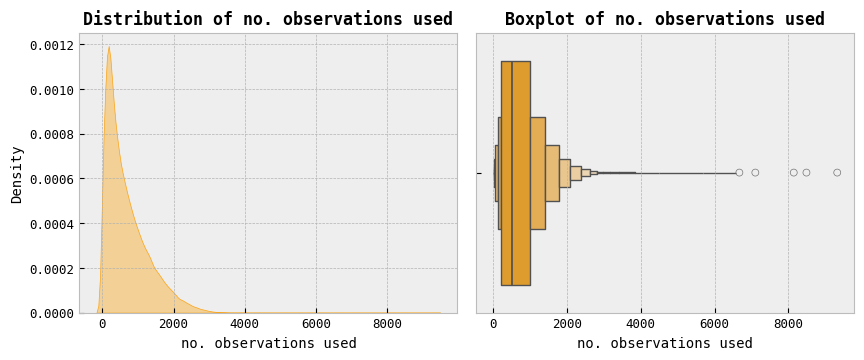

In [47]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='no. observations used', title='Distribution of no. observations used', )
sns.kdeplot(data=asteroid, x='n_obs_used',fill=True, color='#fca311', alpha=.4)

plt.subplot(222, title='Boxplot of no. observations used', )
sns.boxenplot(data=asteroid, x='n_obs_used',color='#fca311')
plt.xlabel('no. observations used')

As for the number of observation, on average the asteroid was observed 499 times during the specific data arc span (which is, commonly, 21 years).

In [48]:
# Convert days to years.
asteroid['data_arc'] = asteroid['data_arc']/365

<Axes: xlabel='data arc span (yrs)', ylabel='class'>

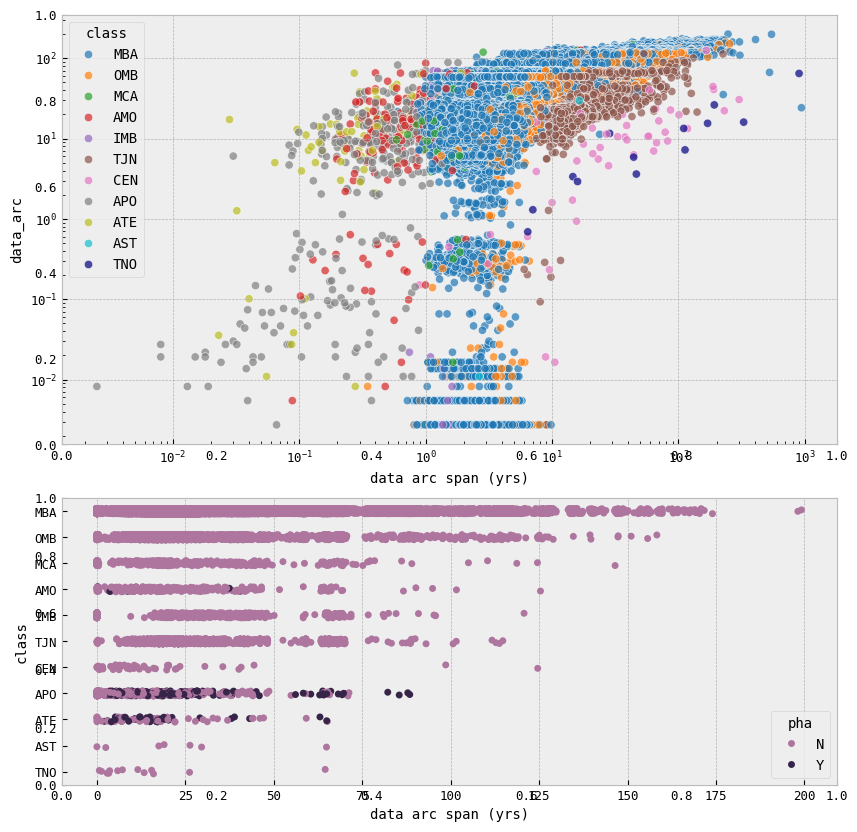

In [49]:
fig, ax = plt.subplots(2,1,figsize=(10,10),gridspec_kw={'height_ratios': [1.5,1]})
plt.subplots_adjust(hspace=0.15)

plt.subplot(211, yscale='log', xscale='log',xlabel='data arc span (yrs)')
sns.scatterplot(data=asteroid, x='diameter', y='data_arc', hue='class', palette=classes_palette, 
                alpha=.7)

plt.subplot(212, xlabel='data arc span (yrs)')
sns.stripplot(asteroid, x='data_arc', y='class', hue='pha', palette=['#ae759f', '#372549'] )

Generally, for different classes of asteroids, the data-arc span can vary significantly depending on their orbits and observational history. 

* NEAs like ATEs, APOs, and AMOs have shorter data-arcs, often less than a year, due to their fast orbital motion and limited observational windows.
* MBAs, including IMBs, OMBs, and MCAs, typically have longer data-arcs, ranging from several years to decades, since they have more stable orbits and have been observed over longer periods.
* CENs and TNOs have even longer data-arcs, often spanning several decades, due to their large distances and slower orbital motion.
* TJNs have data-arcs that are typically several years or more, reflecting their stable orbits in the vicinity of Jupiter.

The number of observations of an asteroid is related to the data arc span. For example, asteroids with short observational arcs, generally, have a lower number of observations, because there are fewer opportunities to make observations during that time.

* NEAs usually have lower numbers of observation compared to MBAs, because they move much faster across the sky due to their proximity to Earth. This makes it more difficult to track them over long periods of time, resulting in fewer observations.

* MBAs and TNOs generally have longer observational arcs because they move more slowly across the sky and are observed over longer periods of time. As a result, there are usually more observations of MBAs and TNOs compared to NEAs.

In addition, sometimes the number of observations is lower than the data arc due to varying asteroid's brightness and observing conditions.

### Feature: `condition_code`

The `condition_code` is a numerical rating that provides information about the quality of the orbital solution for a given asteroid. The condition code ranges from 0 to 9, with 0 indicating a high-quality orbit and 9 indicating a poorly determined orbit. In general, a condition code of 0 or 1 indicates a well-determined orbit, while codes 2-4 indicate a less certain orbit, and codes 5-9 indicate a poorly determined orbit.

 It can be used to assess the accuracy of predictions about the asteroid's future behavior and to identify objects that may require additional observations or analysis to improve the quality of their orbit.

In [50]:
asteroid.condition_code.isnull().sum()

0

C:\Users\lrdvi\AppData\Local\Temp\ipykernel_58484\3742806589.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=asteroid.sort_values(by='condition_code'), x='condition_code',
C:\Users\lrdvi\AppData\Local\Temp\ipykernel_58484\3742806589.py:5: UserWarning: 
The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=asteroid.sort_values(by='condition_code'), x='condition_code',


[Text(0.5, 0, 'condition code'), Text(0, 0.5, 'Count')]

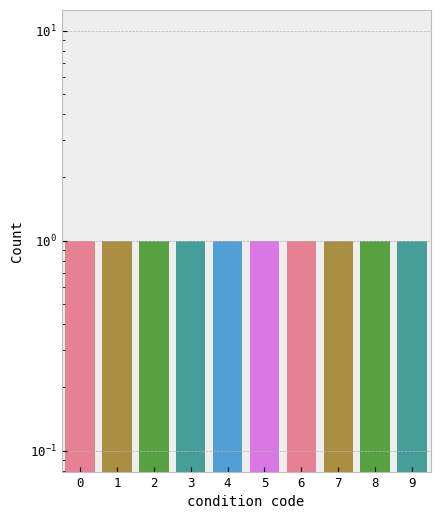

In [51]:
plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.1)

plt.subplot(121, yscale='log',)
sns.countplot(data=asteroid.sort_values(by='condition_code'), x='condition_code', 
              palette=sns.color_palette('husl'))
plt.gca().set(xlabel='condition code', ylabel='Count')

Alright, we see that, fortunately, we have a lot of well-determined orbits from almost every class, but we also have a couple of thousands asteroids with poorly determined orbits and these are mosly MBAs, OMBs and IMBs. Since TNOs' and CENs orbits are usually large, making it difficult to determine them correctly and also decreasing the opportunities to observe these asteroids, it makes sense that some TNOs and CENs have less certain orbits.

Some classes of asteroids, such as NEAs, my be of particular interest to researchers and therefore may have more observational data and a lower condition code due to the efforts of astronomers to accurately determine their orbits,as we see for ATEs, AMOs and APOs.

Overall, there is no specific relationship between the class and condition code, condition code is rather dependent on the number of observations, and we'll check it shortly.

There are a lot of NEAs, such as APOs and AMOs with uncertain orbits. The possible reason for that is that they have really small diameters and may be really difficult to observe, not to mention their short orbital periods.
With so many MBAs in each bin we can not really tell what other classes are there too, so let's take a closer look at each of the classes and find out the ratio of asteroids of specific condition code in each class.

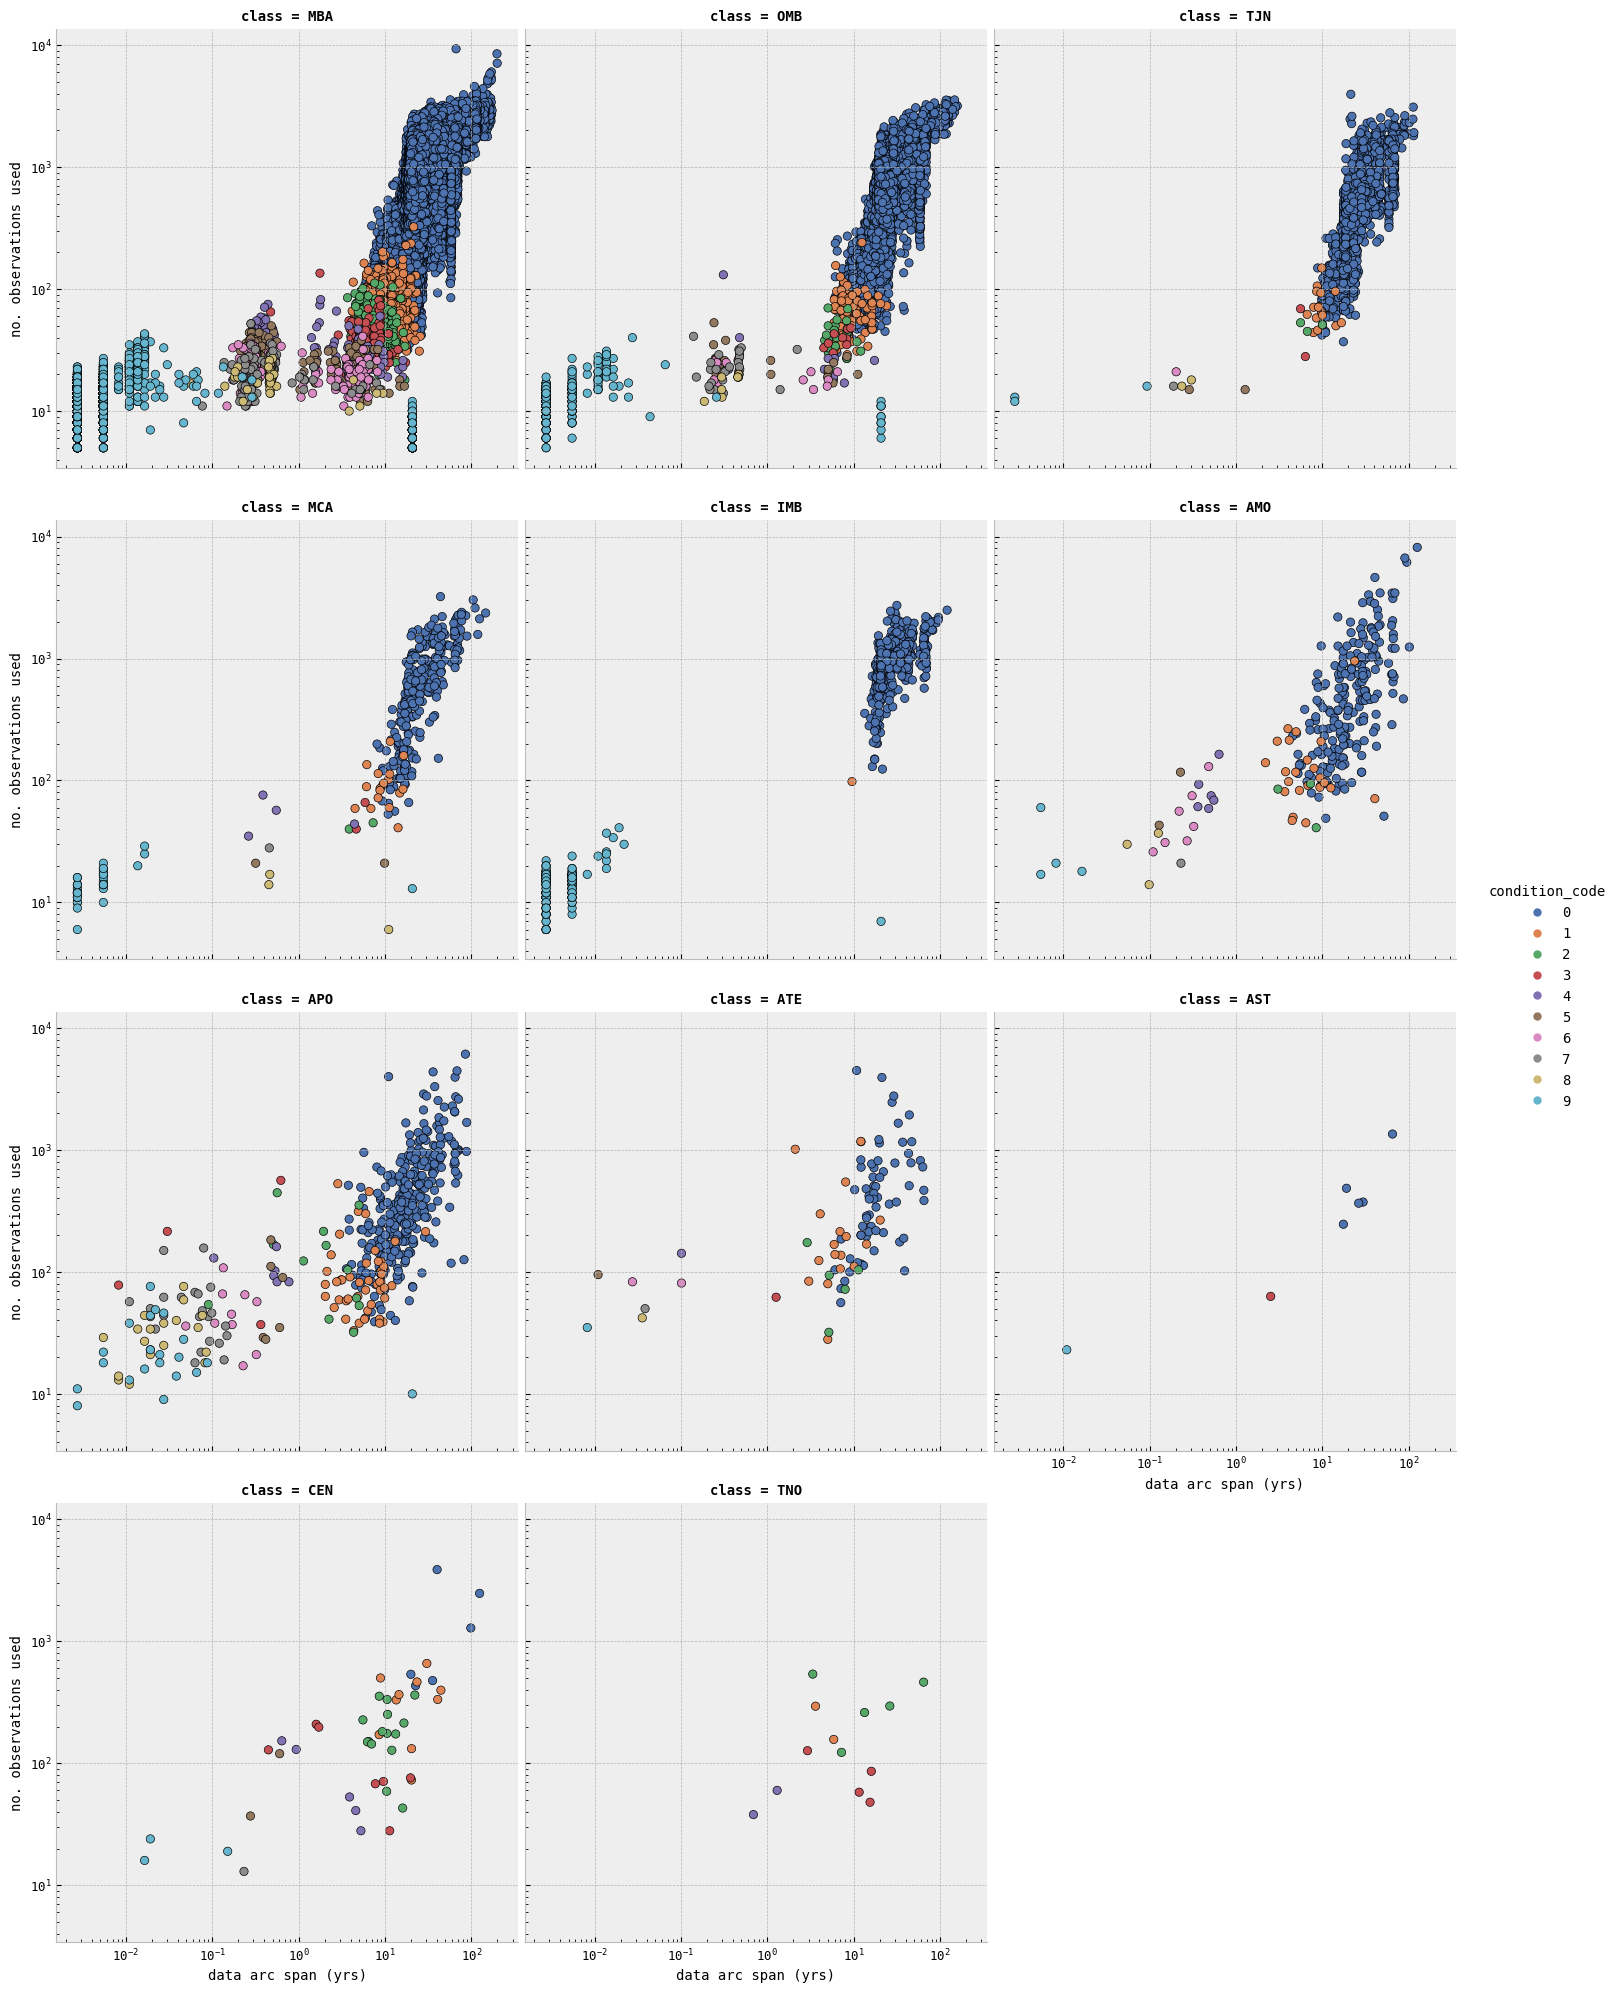

In [52]:
g = sns.relplot(
    data=asteroid.sort_values(by='condition_code'), x="data_arc", y="n_obs_used", col="class",
    hue="condition_code", col_wrap=3, palette='deep', edgecolor='black'
)

g.tight_layout(w_pad=0.5)
g.set(xscale='log', yscale='log', xlabel='data arc span (yrs)', ylabel='no. observations used')

Generally speaking, we see the more the asteroid is observed (longer data-arc), higher is the number of observations on average, which leads to lower condition codes, or more certain orbits, for any class of asteroid.
* MBAs and OMBs: Mostly well-defined orbits. There are some very uncertain orbits with huge data-arcs, but small number of observations. 
* TJNs: Mainly orbits with 0/1 condition codes. There are a couple of asteroids with less certain and poorly determined orbits.
* MCAs: A lot of asteroids with certain orbits. Also, there are asteroids with not well-defined orbits with long data-arcs of 10 years, but only around 10 times actually observed. In comparison, there are asteroids with condition code of 9, which have been observed around 10 times as well, but the data-arc is much shorter - around 1-2 days.
* IMBs: They have usually either well-defined orbits or, if have not been observed for a long time, poorly defined orbits.
* NEAs: AMOs and APOs both usually have condition codes of 0/1, though there are more APOs with higher codes than there are AMOs. Orbits of ATEs are usually well-determined.
* CENs: Despite having the same data-arc and the same quantity of observations, not every CEN has a similar condition score. So most likely, whether the orbit is well-defined after all depends on other characteristics of the asteroid's orbit. Yet, a lot of CENs have codes lower than 5.
* The orbits of TNOs are quite uncertain due to their greater distance from Earth and fewer observations. Still, none of them have very high condition codes.


To sum up, the condition code of an asteroid can be affected by various factors like its size, distance from Earth, how closely its orbit intersects with Earth's orbit, and the quantity of observations. Asteroids with not well-defined orbits but long data-arcs and only a few observations are typically objects that were discovered during a previous appearance and then lost track of for a long time until they were rediscovered during a subsequent appearance. Since their previous observations were spread over a long period of time, their orbits are poorly determined, and additional observations are needed to refine their orbits. 

However, if the asteroid is faint, distant, or moving slowly, it may require a larger telescope or longer exposures to observe, making it more difficult to obtain additional observations. As a result, the asteroid's orbit remains poorly defined despite having a long data-arc. Additionally, the asteroid's position and motion may be affected by various gravitational perturbations, such as those caused by other asteroids, planets, or non-gravitational forces, making it more difficult to accurately determine its orbit.

### Features: `extent`, `rot_per`, `GM`,`BV`, `UB`, `IR`, `spec_B`, `spec_T`, `G`

In [53]:
#description(asteroid)

Almost all the values in certain columns are missing. There is no way we can figure out how to fill them in, and so, we'll just delete these features.

In [54]:
drop_cols = ['extent','rot_per','GM','BV','UB','IR','spec_B','spec_T','G']

asteroid = asteroid.drop(drop_cols, axis=1)

And so we are left with 20 features only. Let's continue exploring the rest of them.

### Feature: `H`

Absolute magnitude is a measure of an object's intrinsic brightness and is defined as  the apparent magnitude (brightness as seen from Earth) the object would have if it were located at a distance of 10 parsecs (about 32.6 light-years) from the observer and illuminated by the sun at a distance of 1 astronomical unit (AU). 

<img src="https://qph.cf2.quoracdn.net/main-qimg-a829b6872ee9d367323641fdc6baaa46-pjlq"/>

__However, the absolute magnitude of asteroids is different than the absolute magnitude used for stars. An asteroid’s absolute magnitude is the visual magnitude an observer would record if the asteroid were placed 1 Astronomical Unit (au) away, and 1 au from the Sun and at a zero phase angle.__

It is denoted by H and is __useful for estimating an asteroid's size__ (we'll make use of this information soon), composition, and surface properties. Lower absolute magnitudes indicate a larger asteroid, while higher absolute magnitudes indicate a smaller asteroid.

<img src="https://i.imgur.com/B8emXvX.png" width="200"/>

<!-- 
<img src="https://users.physics.unc.edu/~reichart/lab5_files/lab5_back_a_01.gif" width="400"/> -->

In [55]:
asteroid.H.isnull().sum()

747

Text(0.5, 0, 'absolute magnitude')

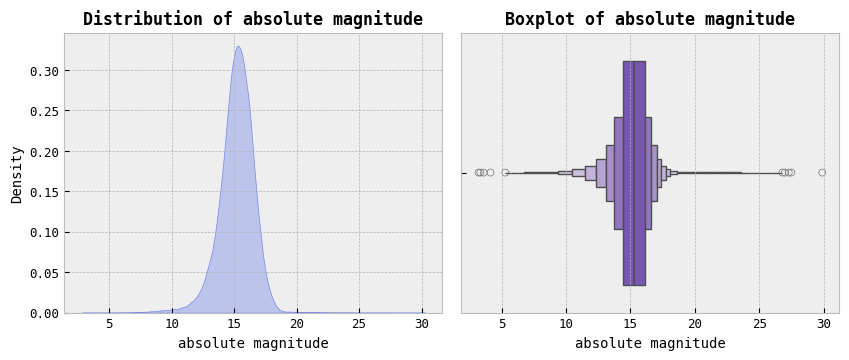

In [56]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='absolute magnitude', title='Distribution of absolute magnitude', )
sns.kdeplot(data=asteroid, x='H',fill=True, color='#7387EB', alpha=.4)

plt.subplot(222, title='Boxplot of absolute magnitude', )
sns.boxenplot(data=asteroid, x='H',color='#7647C2')
plt.xlabel('absolute magnitude')

Most of the asteroids have the absolute magnitude of 15.3 on average, and it indicates that most of asteroids are quite dim.

#### __Missing Values Imputation__

Since we have 747 absolute magnitudes missing, let's fill them in with some values. To determine the fill-in value, we'll take a look at different methods, such as median imputation, logistic regression imputation and knn imputation, and compare them.

In [57]:
# Entries with absolute magnitude missing will be our test set.
missing_h = asteroid['H'].isnull()

In [58]:
# Our train/valid set.
asteroid_no_nan_h = asteroid.dropna(axis=0, subset=['H'])

# We'll use only one feature for predicting H, which is actually highly correlated with it.
X = asteroid_no_nan_h[['n_obs_used']]
y = asteroid_no_nan_h['H']
                  
# Split into train and validation sets.
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=SEED)

In [59]:
X_test = asteroid.loc[missing_h, ['n_obs_used']]

# Train models and check performance on validation set.
lr = LinearRegression().fit(X_tr, y_tr)
knn = KNeighborsRegressor(n_neighbors=15, weights='distance').fit(X_tr, y_tr)

print('>> LR: {}'.format(mean_squared_error(y_val, lr.predict(X_val))))
print('>> KNN: {}'.format(mean_squared_error(y_val, knn.predict(X_val))))

# Make predictions for the test set.
lr_test_pred = lr.predict(X_test)
knn_test_pred = knn.predict(X_test)

>> LR: 0.7661167544896129
>> KNN: 0.7877440482713963


In [60]:
# Make a copy of the original dataset with new columns representing H column with imputed values 
# using different techniques.
asteroid_imputed_H = asteroid.copy()

for col_name, preds in zip(['H_imp_lr', 'H_imp_knn', 'H_imp_median'],
                           [lr_test_pred, knn_test_pred, asteroid_imputed_H.H.median()]):
    asteroid_imputed_H[col_name] = asteroid['H']
    asteroid_imputed_H.loc[missing_h, col_name] = preds

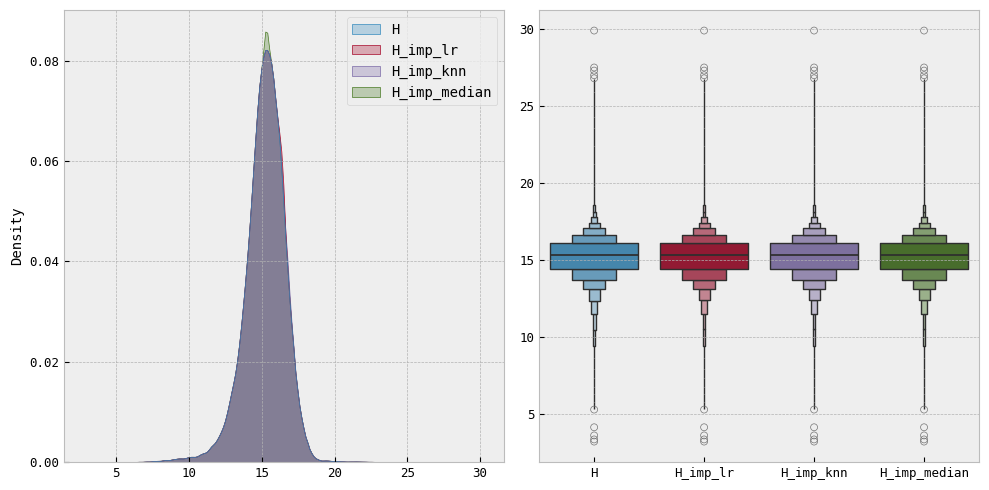

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

imp_res = asteroid_imputed_H[['H','H_imp_lr', 'H_imp_knn', 'H_imp_median']]

sns.kdeplot(data=imp_res, ax=ax[0], alpha=.3, fill=True)
sns.boxenplot(data=imp_res, ax=ax[1])
plt.tight_layout()

We see that no matter which imputation technique we use, each one gives us the same results on average.

Usually if the imputed mean and median values from the regression/knn method are very close to the mean and median computed from the non-null entries in the dataset, it could suggest that the imputation method is not introducing significant bias into the analysis. This could indicate that the missing values are missing at random and that the imputation method is successfully capturing the patterns in the data.

Thus, it seems that any imputation method is a reasonable option for filling in the missing values.

In [62]:
asteroid.loc[missing_h, 'H'] = lr_test_pred
asteroid.H.isnull().sum()

0

Before exploring any relationships between absolute magnitude and other features, we'll take a look at the`albedo` feature, so that we could make our analysis richer.

### Feature: `albedo`

Albedo in the context of asteroids refers to the measure of the reflectivity of an asteroid's surface. It is defined as the fraction of solar radiation that is reflected by the asteroid's surface. Albedo is usually measured on a scale of 0 to 1, where 0 represents an object that absorbs all incoming radiation and 1 represents an object that reflects all incoming radiation.

Asteroids with higher albedo appear brighter in telescopes and have a more reflective surface, while asteroids with lower albedo appear darker and have a more absorptive surface. To compare, our Moon has a very low albedo (0.07), while Venus has a high albedo (0.60).


<img src="https://static.manitobacooperator.ca/wp-content/uploads/2020/03/24104104/albedo.jpg" width="600"/>


<img src="https://i.ytimg.com/vi/aCDj0tmK7ZQ/mqdefault.jpg" width="500"/>

 __The albedo combined with the absolute magnitude can help determine the size of an asteroid.__

In [63]:
asteroid.albedo.isnull().sum()

1230

Text(0.5, 0, 'geometric albedo')

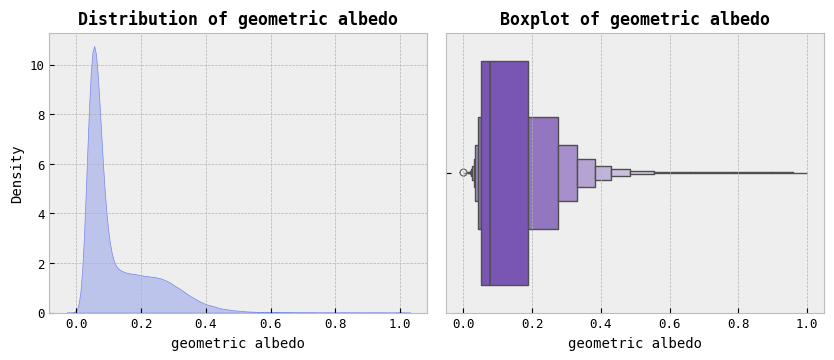

In [64]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='geometric albedo', title='Distribution of geometric albedo', )
sns.kdeplot(data=asteroid, x='albedo',fill=True, color='#7387EB', alpha=.4)

plt.subplot(222, title='Boxplot of geometric albedo', )
sns.boxenplot(data=asteroid, x='albedo',color='#7647C2')
plt.xlabel('geometric albedo')

So we see that most of the asteroids appear to be dim and absorptive, since they have 0.078 albedo on average.

#### __Missing Values Imputation__

We'll take the same approach to imputing missing values, as we have done for `H`.

In [65]:
# Entries with albedo missing - test set.
missing_albedo = asteroid['albedo'].isnull()

In [66]:
asteroid_no_nan_albedo = asteroid.dropna(axis=0, subset=['albedo'])

X = asteroid_no_nan_albedo[['diameter']]   # highly correlated with albedo
y = asteroid_no_nan_albedo['albedo']
                  
# Create train and validation sets.
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=SEED)

In [67]:
X_test = asteroid.loc[missing_albedo, ['diameter']]

# Train models and check performance on validation set.
lr = LinearRegression().fit(X_tr, y_tr)
knn = KNeighborsRegressor(n_neighbors=5, weights='distance').fit(X_tr, y_tr)

print('>> LR: {}'.format(mean_squared_error(y_val, lr.predict(X_val))))
print('>> KNN: {}'.format(mean_squared_error(y_val, knn.predict(X_val))))

# Predict the test set values.
lr_test_pred = lr.predict(X_test)
knn_test_pred = knn.predict(X_test)

>> LR: 0.011894735521214783
>> KNN: 0.01338324107143534


In [68]:
# Make a copy of the dataset with new columns representing H column with imputed values using 
# different techniques.
asteroid_imputed_albedo = asteroid.copy()

for col_name, preds in zip(['albedo_imp_lr', 'albedo_imp_knn', 'albedo_imp_median'],
                           [lr_test_pred, knn_test_pred, asteroid_imputed_albedo.albedo.median()]):
    asteroid_imputed_albedo[col_name] = asteroid['albedo']
    asteroid_imputed_albedo.loc[missing_albedo, col_name] = preds

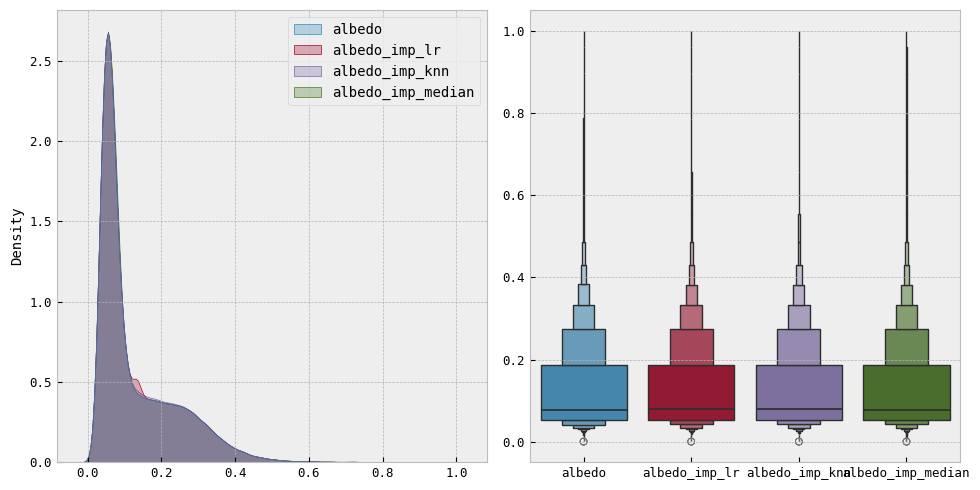

In [69]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

imp_res = asteroid_imputed_albedo[['albedo','albedo_imp_lr', 'albedo_imp_knn', 'albedo_imp_median']]

sns.kdeplot(data=imp_res, ax=ax[0], alpha=.3, fill=True)
sns.boxenplot(data=imp_res, ax=ax[1])
plt.tight_layout()

Essentially, we got the same results, as for absolute magnitude. There is no actual difference in which imputation technique we'll use.

In [70]:
asteroid.loc[missing_albedo, 'albedo'] = knn_test_pred
asteroid.albedo.isnull().sum()

0

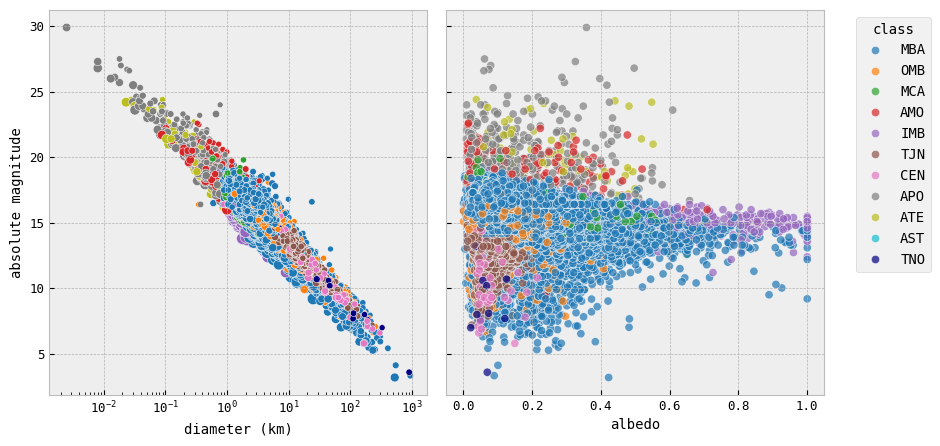

In [71]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.subplots_adjust(wspace=0.05)

ax[0].set(xscale='log', xlabel='diameter (km)', ylabel='absolute magnitude')
sns.scatterplot(asteroid, x='diameter', y='H', hue='class', palette=classes_palette, 
                size='albedo', ax=ax[0])
ax[0].legend().set_visible(False)

ax[1].set(xlabel='albedo',)
sns.scatterplot(asteroid, x='albedo', y='H', hue='class', palette=classes_palette, alpha=.7,
                ax=ax[1])
sns.move_legend(ax[1], "upper right", bbox_to_anchor=(1.3, 1.),)

* In general, smaller asteroids have higher absolute magnitudes (i.e., are darker), while larger asteroids have lower absolute magnitudes (i.e., are brighter). Albedo also plays a role, as objects with higher albedo (i.e., they reflect more light) have lower absolute magnitudes.
* MBAs have a relatively uniform distribution of absolute magnitudes, with a mean value of around H=13. There also can be noticed a slight trend for smaller asteroids to have higher absolute magnitudes, and for larger asteroids to have lower absolute magnitudes. This class spans all albedo values. Most of the time asteroids with albedo around 14 may have high albedos (greater than 0.6), but MBAs with H > 14 and H < 14 usually have albedo < 0.6. And the brighter the MBA is, the larger it is, then its albedo gets lower.
* IMBs are known for having high albedos compared to other asteroid classes. This is because they are composed of silicate rocks, which are more reflective than other materials such as carbonaceous chondrites that are found in outer main belt asteroids. Additionally, many IMBs have undergone space weathering, a process that can make their surfaces brighter by removing the darker outer layer of material and revealing the brighter interior.
* OMBs and MCAs usually have low albedos and follow the general rule of lower H leading to greater size.
* NEAs seem to have higher albedos when they are brighter (absolute magnitude is lower) and larger. Still, despite their proximity to the Sun, their albedos are much lower than these of MBAs sometimes, and never are higher than 0.6.
* For TJNs, there is a correlation between absolute magnitude and diameter, with brighter asteroids generally being larger, and also having higher albedos.
* The general rule applies to CENs too, since brighter CENs are often larger too, but they do not neccessarily have an increase in albedo. Most of them have really low albedos. They have a relatively uniform distribution of absolute magnitudes, with a mean value of around H=10.
* TNOs have a wide range of absolute magnitudes. Brighter TNOs generally are larger too, but not less absorptive.

### Feature: `moid`

MOID stands for Minimum Orbit Intersection Distance. It is a measure of the closest approach of two celestial objects, typically asteroids and planets. Specifically, in our dataset the MOID of an asteroid is the minimum distance between its orbit and the orbit of Earth (usually a planet) at the point where the two orbits intersect.

The MOID is a useful measure for assessing the potential for collisions between asteroids and planets. If the MOID between an asteroid and a planet is small, then there is a higher probability that the asteroid could collide with the planet at some point in the future. The MOID is often used in conjunction with other measures, such as the relative velocities of the two objects, to calculate the likelihood of a collision.

In [72]:
asteroid.moid.isnull().sum()

0

Text(0.5, 0, '')

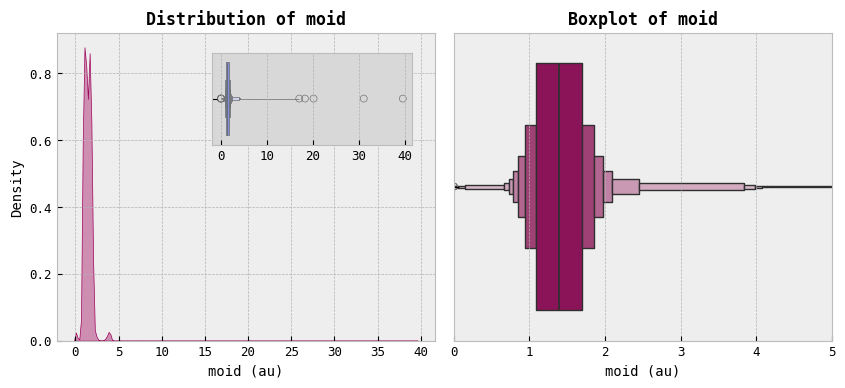

In [73]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='moid (au)', title='Distribution of moid')
sns.kdeplot(data=asteroid, x='moid',fill=True, color='#9e0059', alpha=.4)

plt.subplot(122, title='Boxplot of moid', xlim=(0,5))
sns.boxenplot(data=asteroid, x='moid',color='#9e0059')
plt.xlabel('moid (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='moid', saturation=.8, color='#7387EB', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

The plots suggest that the most common minimum orbit intersection distance between the asteroid and Earth is around 1.5 au.

<Axes: xlabel='moid (au)', ylabel='absolute magnitude'>

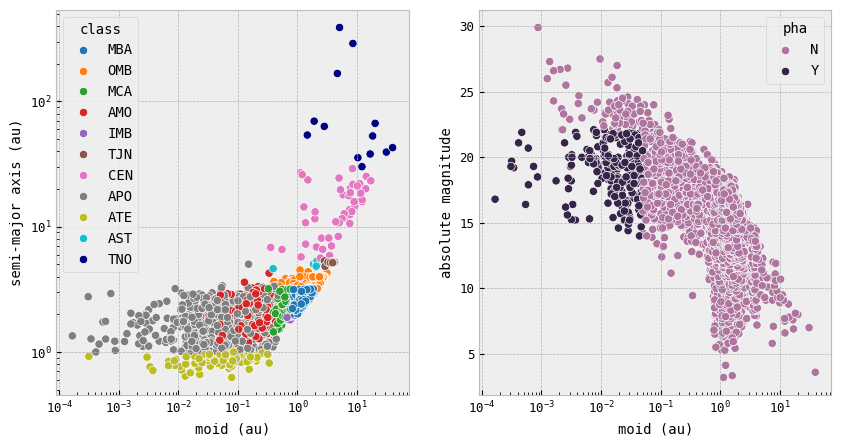

In [74]:
fig, ax = plt.subplots(1,2,figsize=(10,5), )
plt.subplots_adjust(wspace=.2)


ax[0].set(xscale='log', yscale='log', xlabel='moid (au)', ylabel='semi-major axis (au)')
sns.scatterplot(asteroid, x='moid', y='a', hue='class', palette=classes_palette, ax=ax[0])

ax[1].set(xscale='log',xlabel='moid (au)', ylabel='absolute magnitude')
sns.scatterplot(asteroid, x='moid', y='H', hue='pha', ax=ax[1], palette=['#ae759f', '#372549'])

* NEAs are more likely to have smaller MOIDs due to their proximity to Earth and their orbits that intersect Earth's orbit. 
* MBAs generally have larger MOIDs because they have more circular orbits and are located farther from Earth.

* As we recall, only NEAs whose `moid` < 0.05 and whose `H` <= 22.0 may usually be considered PHAs. And our plot on the right tells that asteroids in our dataset are entirely in accord with the statement.

<Axes: xlabel='moid (au)', ylabel='diameter (km)'>

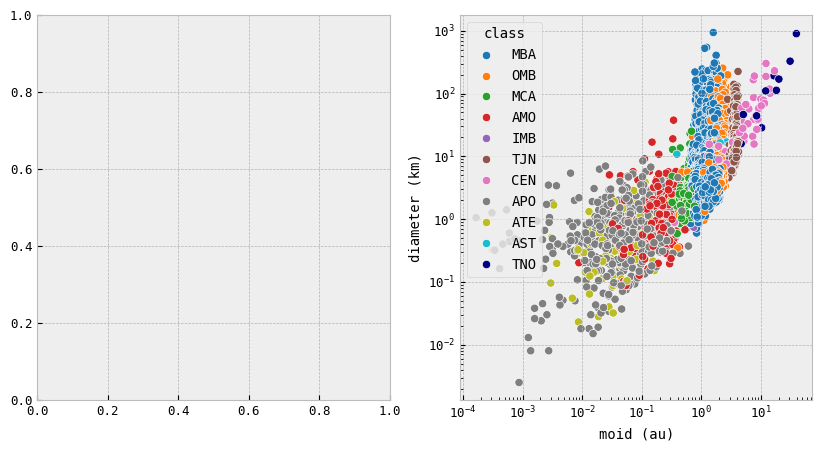

In [75]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[1].set(xscale='log', yscale='log', xlabel='moid (au)', ylabel='diameter (km)')
sns.scatterplot(asteroid, x='moid', y='diameter', hue='class', palette=classes_palette, ax=ax[1])

The plot on the left tells us that all of the PHAs are indeed NEAs with moid < 0.55 au. On the contrary, the plot on the right reveals that there is no straightforward relationship between minimum orbital intersection distance (MOID) and diameter for different classes of asteroids, since MOID depends on the orbit of the asteroid and its closest approach to the orbit of Earth, and the diameter is related to other factors.

### Feature: `n`

Mean motion in the context of asteroids refers to the average angular speed at which an asteroid travels along its orbit around the Sun. It is the rate at which the asteroid completes one revolution around the Sun, and is expressed in units of degrees per day. 

The mean motion is equal to the average angular frequency $w$ of a body in elliptical orbit, and is defined by $n = \frac {2 \pi}{T}$, where $T$ is the orbital period. 

Again mean Motion doesn't provide any new information

In [76]:
asteroid.n.isnull().sum()

0

Text(0.5, 0, 'mean motion (deg/d)')

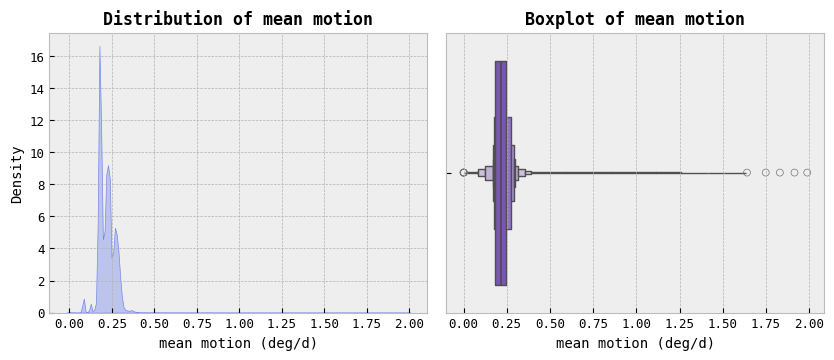

In [77]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='mean motion (deg/d)', title='Distribution of mean motion', )
sns.kdeplot(data=asteroid, x='n',fill=True, color='#7387EB', alpha=.4)

plt.subplot(222, title='Boxplot of mean motion', )
sns.boxenplot(data=asteroid, x='n',color='#7647C2')
plt.xlabel('mean motion (deg/d)')

The common value for mean motion for an asteroid is around 0.21 deg/d. Let's now check what classes of asteroids have lower or higher mean motions and check the relationships between mean motion and other features.

* The Atens, Apollos, and Amors (NEAs) have the highest mean motions since their orbits bring them close to the Earth's orbit. 
* IMBs usually move faster than MBAs, and MBAs have higher mean motions than OMBs.
* CENs and TNOs have very low mean motions since they are far from the Sun and move more slowly in their orbits.

Mean motion is not directly related to the diameter of the asteroid for different classes of asteroids. Though, it can indirectly affect the diameter of the asteroid through its influence on the asteroid's orbit and its proximity to the Sun. For example, asteroids with shorter orbital periods and smaller semi-major axes, such as APOs, tend to have higher mean motions and may experience more frequent close encounters with the Sun, which can cause thermal stresses that could lead to fragmentation or erosion of the asteroid's surface. This, in turn, could affect the asteroid's diameter over time. Stull, the relationship depends on different factors such as the composition of the asteroid, environment etc.

As expected, both plots confirm that $n \propto 1/T $ and $n \propto 1/ a^{3/2}$.

### Feature: `ma`

Mean anomaly is an orbital parameter that specifies the angle between the current position of an asteroid and its position at a hypothetical time when it was at its perihelion, assuming a perfectly circular orbit. It is a measure of the asteroid's progress along its orbit, and increases uniformly with time.

It also doesn't provide any unique information regarding the size.

In [78]:
asteroid.ma.isnull().sum()

0

Mean anomaly spans all values, with the median of 187 deg.

### Correlation plot

['q', 'data_arc', 'n_obs_used', 'H', 'diameter']

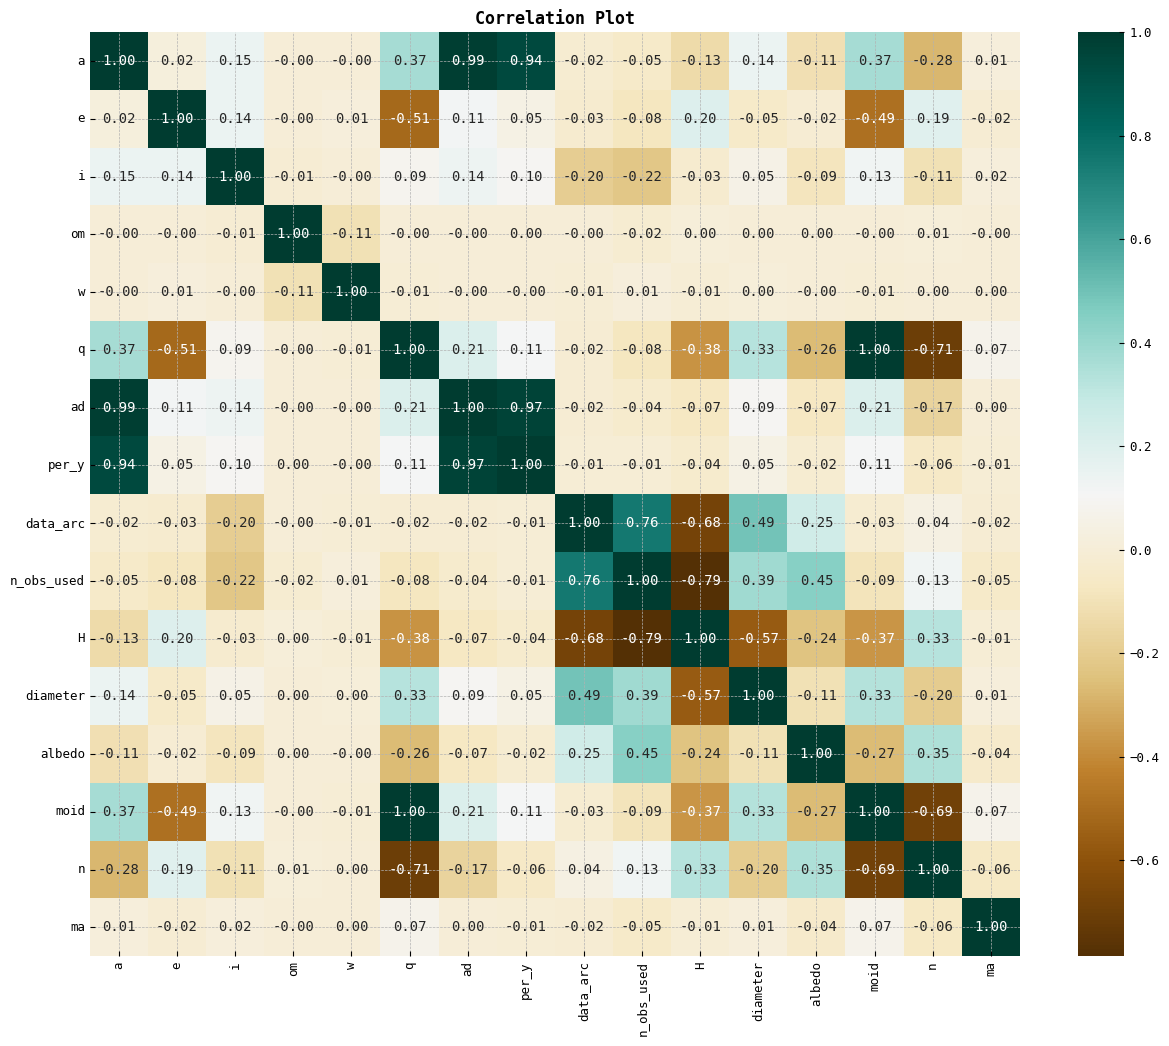

In [79]:
plt.figure(figsize=(15,12))

asteroid_corr_plot = asteroid.select_dtypes(include=['float64', 'int64'])
correlation_matrix = asteroid_corr_plot.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', fmt='.2f',)
plt.title('Correlation Plot')

selected_features = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'data_arc', 'condition_code',
                     'n_obs_used', 'H', 'ma']
correlation_matrix = asteroid[selected_features + ['diameter']].corr()


correlation_threshold = 0.3  # Adjust as needed
highly_correlated_features = correlation_matrix['diameter'][abs(correlation_matrix['diameter']) > correlation_threshold].index.tolist()
highly_correlated_features

We notice that there are a lot highly correlated features. There are some of them:
* semi-major axis `a` and aphelion distance `ad`
* semi-major axis `a` and orbital period `per_y`
* perihelion distance `q` and mean motion `n`
* aphelion distance `ad` and orbital period `per_y` and so on.

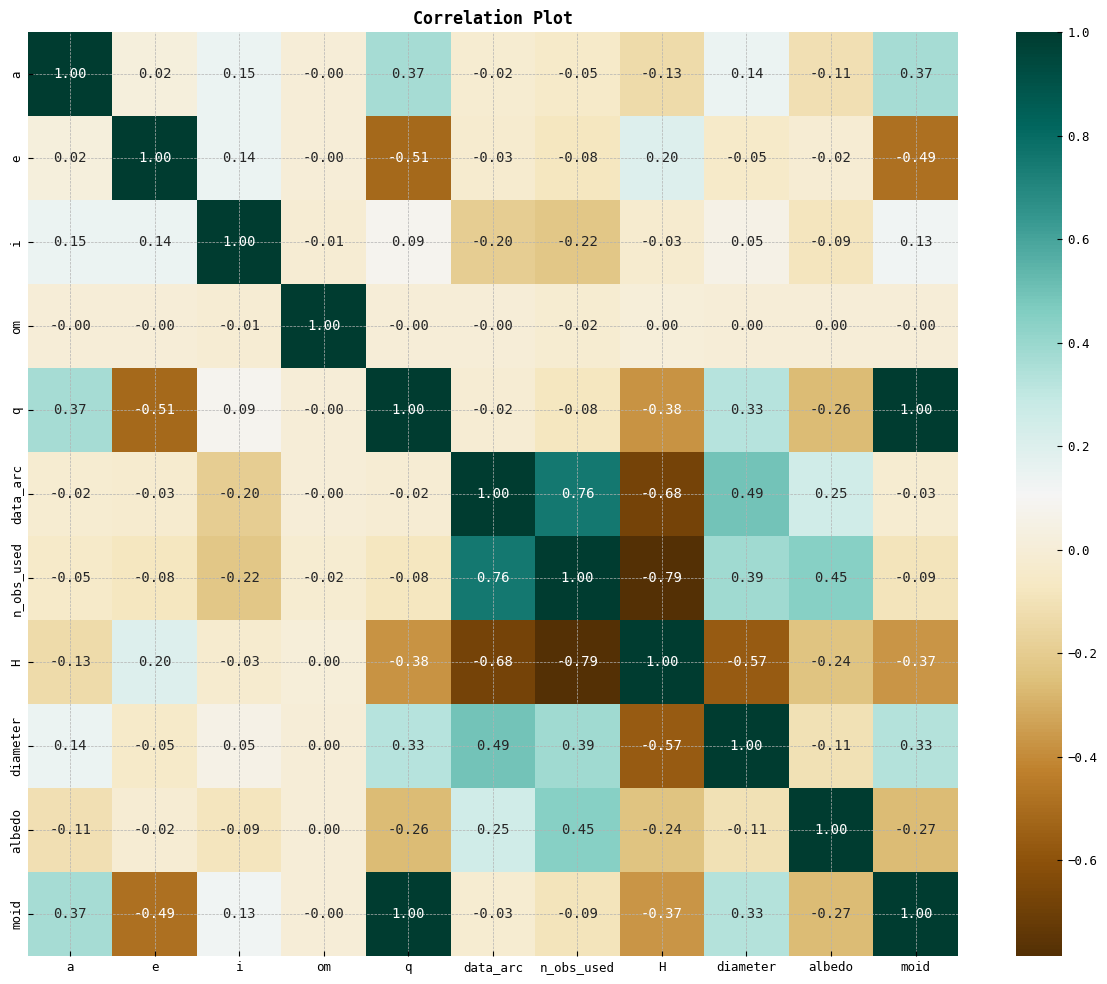

In [80]:
# Assuming 'asteroid' is your DataFrame
columns_to_remove = ['w','n', 'ad','per_y','ma']

asteroid_filtered = asteroid.drop(columns=columns_to_remove, errors='ignore')

# 'errors' parameter is set to 'ignore' to prevent errors if a column is not found

plt.figure(figsize=(15,12))

asteroid_filtered_corr = asteroid_filtered.select_dtypes(include=['float64', 'int64'])
sns.heatmap(asteroid_filtered_corr.corr(), annot=True, cmap='BrBG', fmt='.2f',)
plt.title('Correlation Plot')
plt.savefig('plot_corr_II.png')

#### Recursive Feature Elimination (RFE)
It is a feature selection technique that recursively removes the least important features based on the coefficients of a model.

RFE process assigns a ranking to each feature based on their importance in predicting the target variable. 
The RFE algorithm assigns a ranking to each feature. A lower ranking indicates higher importance. The feature with a ranking of 1 is considered the most important according to the RFE process. Features with higher rankings are considered less important or redundant.

In [81]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Assuming 'asteroid' is your DataFrame
# Drop rows with missing values in the target variable 'diameter'
asteroid = asteroid.dropna(subset=['diameter'])

# Select features and target variable
selected_features = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'data_arc', 'condition_code',
                     'n_obs_used', 'H','ma']
#X = asteroid_transf.drop(['diameter'], axis=1
X = asteroid[selected_features]
y = asteroid['diameter']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
model = LinearRegression()

# Initialize RFE with the model and desired number of features to select
num_features_to_select = 10  # Adjust as needed
rfe = RFE(model, n_features_to_select=num_features_to_select)

# Fit RFE to training data
rfe.fit(X_train_scaled, y_train)

# Get the selected features
selected_features_rfe = X.columns[rfe.support_]

# Visualize the ranking of features
ranking_df = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
ranking_df = ranking_df.sort_values(by='Ranking')

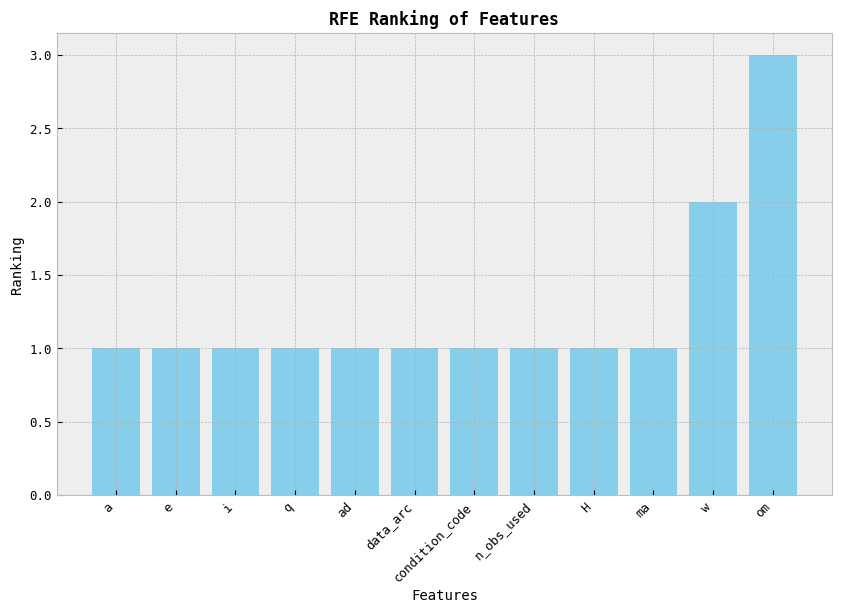

In [82]:
# Plot the ranking of features
plt.figure(figsize=(10, 6))
plt.bar(ranking_df['Feature'], ranking_df['Ranking'], color='skyblue')
plt.title('RFE Ranking of Features')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation=45, ha='right')
plt.savefig('plot_RFE_I.png')
plt.show()

<a id="ENG_PROC"></a>
# Feature Engineering and Data Preprocessing

So far, after removing features with a lot of missing entries or those that wouldn't benefit the model and as well filling in the missing values if possible, we are left with 20 features out of 31 that we had originally. Most of these features are numerical, and we won't be performing a lot of changes to them in this section. However, there are a couple of features, which present categorical data, such as `condition_code`, `neo`, `pha`, `class`. We notice that `condition_code` is already a number, even though it subtly carries a deeper meaning than just a simple number, but for other variables, we would need to convert them to numerical values, i.e. encode them. 

#### But first, we will compute a __crucial__ and definitely worthy of your attention feature from existing columns. You may call this feature __a trick to predicting the diameters of asteroids better.__

In [83]:
#asteroid
asteroid_filtered

a         e          i          om         q    data_arc  \
0       2.769165  0.076009  10.594067   80.305532  2.558684   24.169863   
1       2.772466  0.230337  34.836234  173.080063  2.133865  198.131507   
2       2.669150  0.256942  12.988919  169.852760  1.983332  199.134247   
3       2.361418  0.088721   7.141771  103.810804  2.151909   66.542466   
4       2.574249  0.191095   5.366988  141.576605  2.082324  173.991781   
...          ...       ...        ...         ...       ...         ...   
797860  3.171225  0.159119  27.098625  309.036573  2.666623    6.501370   
798077  2.548410  0.076071  11.593237  246.298656  2.354549    9.032877   
798189  3.146246  0.220559  17.966646  137.981403  2.452313    7.778082   
799752  3.051336  0.287449  14.456779  343.917822  2.174231    6.049315   
810375  2.417477  0.109001   4.525668  148.244819  2.153970    9.473973   

       condition_code  n_obs_used      H neo pha  diameter  albedo     moid  \
0                   0        1002   3.34   N   N   939.400  0.0900  1.59478   
1                   0        8490   4.13   N   N   545.000  0.1010  1.23324   
2                   0        7104   5.33   N   N   246.596  0.2140  1.03454   
3                   0        9325   3.20   N   N   525.400  0.4228  1.13948   
4                   0        2916   6.85   N   N   106.699  0.2740  1.09589   
...               ...         ...    ...  ..  ..       ...     ...      ...   
797860              1          50  16.20   N   N     3.793  0.0210  1.66301   
798077              2          33  17.30   N   N     2.696  0.0610  1.36733   
798189              1          47  16.80   N   N     2.917  0.1426  1.43837   
799752              2          27  17.20   N   N     3.271  0.0720  1.16684   
810375              3          25  18.40   N   N     1.600  0.0230  1.15942   

       class  
0        MBA  
1        MBA  
2        MBA  
3        MBA  
4        MBA  
...      ...  
797860   MBA  
798077   MBA  
798189   MBA  
799752   MBA  
810375   MBA  

[137636 rows x 15 columns]

#### Trick: Approximate Asteroid Diameter Feature

Very few asteroids have “known” sizes (or shapes). Most asteroids have irregular shapes (that is, very few are close to being spherical). However, the size (diameter of an equivalent sphere) of an asteroid can be estimated from its absolute magnitude `H` and an assumed geometric `albedo`, as we have seen earlier. The expression for diameter `d` in km as a function of absolute magnitude H and geometric albedo a is given by the following equation:

$d = 10^{[3.1236 - 0.5log{_{10}}{(a)}-0.2H]}$

In [84]:
def estimate_diameter(a, H):
    '''A function for computing approximate asteroid diameter from its albedo and absolute magnitude.'''
    p = 3.1236 - 0.5*np.log10(a) - 0.2*H
    return 10**p

In [85]:
asteroid_transf = asteroid_filtered.copy()
asteroid_transf['approx_diameter']=estimate_diameter(asteroid_transf.albedo, asteroid_transf.H)

Now that we have computed the approximate diameters, let's look how far our generated values are from actual diameters.

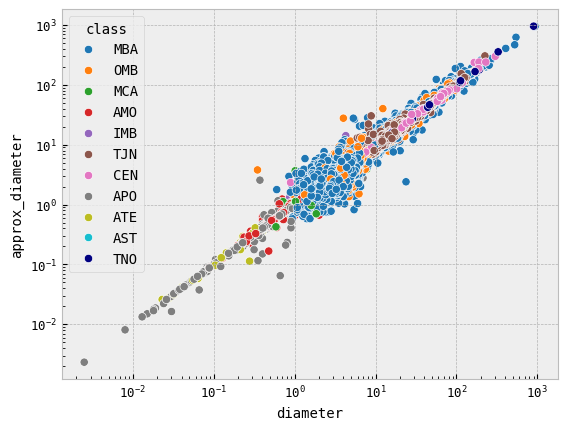

In [86]:
sns.scatterplot(data=asteroid_transf, x='diameter', y='approx_diameter',hue='class',
                palette=classes_palette)
plt.gca().set(xscale='log', yscale='log');

Whoa, the relationship between the approximate diameter and our actual diameter is almost perfectly linear. There are some values that are a bit off, but for majority of asteroids the computed diameter is approximately equal to the actual diameter! That's great news! Now we can use this feature to train our models and better results! 

##### However, its certainly worth it to check what the performance will look like if we don't use this feature. This will make training the model to achieve high results without a doubt challenging, but we will give it a try and compare the results!

#### Encoding the categorical features

Here we will make use of a usual encoding method for categorical features, and that will be one-hot encoding. Our models won't suffer from dimensionality curse just from one-hot encoding a couple of categorical columns, so we will get on with it.

In [87]:
# Perform one-hot encoding on categorical columns 
asteroid_transf = pd.get_dummies(asteroid_transf, dtype=int)
asteroid_transf.head()

a         e          i          om         q    data_arc  \
0  2.769165  0.076009  10.594067   80.305532  2.558684   24.169863   
1  2.772466  0.230337  34.836234  173.080063  2.133865  198.131507   
2  2.669150  0.256942  12.988919  169.852760  1.983332  199.134247   
3  2.361418  0.088721   7.141771  103.810804  2.151909   66.542466   
4  2.574249  0.191095   5.366988  141.576605  2.082324  173.991781   

   n_obs_used     H  diameter  albedo  ...  class_APO  class_AST  class_ATE  \
0        1002  3.34   939.400  0.0900  ...          0          0          0   
1        8490  4.13   545.000  0.1010  ...          0          0          0   
2        7104  5.33   246.596  0.2140  ...          0          0          0   
3        9325  3.20   525.400  0.4228  ...          0          0          0   
4        2916  6.85   106.699  0.2740  ...          0          0          0   

   class_CEN  class_IMB  class_MBA  class_MCA  class_OMB  class_TJN  class_TNO  
0          0          0          1          0          0          0          0  
1          0          0          1          0          0          0          0  
2          0          0          1          0          0          0          0  
3          0          0          1          0          0          0          0  
4          0          0          1          0          0          0          0  

[5 rows x 37 columns]

#### Train-test split

Alright, we have performed feature engineering and encoded categorical features from our dataset. To move on to scaling numerical features, we would first need to create our train/test splits, and also validation split for fine-tuning our models. We will use 30% of the data for testing, 58% for training, and 12% for validation.

In [88]:
X = asteroid_transf.drop(['diameter'], axis=1)
y = asteroid_transf[['diameter']]

# Split into train/val and test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=SEED)
# Split into train set and val set.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.2, random_state=SEED)

In [89]:
# Reset the index of each set after splitting.
X_train, X_val = X_train.reset_index(drop=True), X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

#### Scaling numerical features

Now we can standardize our numerical features to boost performance if possible. For that we first fit `StandardScaler()` on the training set and then transform each of the sets without fitting. Otherwise if we recalculate the values for each set, the values would be inconsistent with the model and this would produce wrong predictions.

In [90]:
num_cols = ['a', 'e', 'i', 'q', 'om', 'data_arc', 'n_obs_used',
            'H', 'albedo', 'moid','approx_diameter']

scaler = StandardScaler()

# Scale the numerical features and then join these features with categorical ones.
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
X_train_sc = pd.concat([X_train_sc, X_train.loc[:, ~X_train.columns.isin(num_cols)]], 
                       axis=1)

X_val_sc = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
X_val_sc = pd.concat([X_val_sc, X_val.loc[:, ~X_val.columns.isin(num_cols)]], 
                       axis=1)

X_test_sc = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
X_test_sc = pd.concat([X_test_sc, X_test.loc[:, ~X_test.columns.isin(num_cols)]], 
                       axis=1)

In [91]:
scaler = StandardScaler()

# Scale the target variable.
y_train_sc = scaler.fit_transform(y_train)
y_val_sc, y_test_sc = scaler.transform(y_val), scaler.transform(y_test)

y_train_sc.shape, y_val_sc.shape, y_test_sc.shape

((88086, 1), (22022, 1), (27528, 1))

<a id="Models"></a>
# Building and Fine-Tuning the Models

In this section, the primary focus will be on constructing and fine-tuning three models: MLP neural network, CatBoost, and Light GBM. By exploring and optimizing these models, I aim to identify the most suitable one for our specific task - prediction of asteroid diameter. Through a comparative analysis of their performance, you will see me make an informed decision about which model yields the best results.

__Metrics: R2 and MSE__

To evaluate the goodness-of-fit of a model, we will use the R2 metric, also known as the coefficient of determination, is a statistical measure commonly used in regression analysis. It provides an indication of how well the dependent variable (target) is predicted by the independent variables (features) in a regression model. It takes values between 0 and 1, where R2 = 0 indicates that the model does not explain any of the variability in the target variable and R2 = 1 indicates that the model perfectly predicts the target variable. 

Of course, R2 has its limitations. It can be influenced by the number of independent variables and may not capture the full complexity of the relationship between the variables. Therefore, it is often used in conjunction with other evaluation metrics to get a more comprehensive understanding of the model's performance. To account for that we will also use MSE metric to make sense of model's performance.

__Data: entire dataset and dataset without `approx_diameter` feature__

In this section, we will be using two datasets: one containing `approx_diameter` feature and the one without it. It's just a matter of satisfying my curiosity, still I think it's worth it to see how different the results will be and how huge a role this feature may play in accurate predictions.

In [92]:
def evaluation_scatterplot(y_pred, y_true, **scatter_kwargs):  
    ''' 
    Creates a scatter plot of predictions and true values with logarithmic scale. Plots a diagonal line, 
    computes MSE & R2 scores for the values and adds them to the plot as an annotation.
    '''
    ax = sns.scatterplot(x=y_true['diameter'].ravel(), y=y_pred.flatten(), **scatter_kwargs)
    
    # Calculate diagonal line equation for the original scale
    x = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]), num=100)
    y = x  
    
    # Plot the diagonal line in the logarithmic scale
    plt.plot(x, y, 'k--', lw=2)
    
    # Add annotation in the upper-left corner
    mse = mean_squared_error(y_true, y_pred).round(3)
    r2 = r2_score(y_true, y_pred).round(3)
    results= "MSE: {:.3f}\n R2: {:.3f}".format(mse,r2)
    plt.text(0.05, 0.95, results, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    return ax, mse, r2

In [93]:
# Reduced dataset
X_train_sc_red = X_train_sc.drop(['approx_diameter'], axis=1)
X_val_sc_red = X_val_sc.drop(['approx_diameter'], axis=1)
X_test_sc_red = X_test_sc.drop(['approx_diameter'], axis=1)
X_train.shape[1]

36

<a id="MLP"></a>
# 2-Layered Neural Network (2LNN) for Regression

We will kick it off with something simple (I mean, in comparison to other more advanced neural network architectures..), and that will be a neural network model that comes under __Multilayer Perceptron__. 

The model will be constructed using a sequential architecture, where layers are stacked sequentially on top of each other. In the context of regression (what we are planning to do), an MLP model is trained to predict continuous numerical values based on input features. Generally, it consists of an input layer, one or more hidden layers with activation functions, and an output layer that produces the regression prediction. MLP models are widely used in machine learning for regression tasks due to their ability to capture complex relationships between input features and target variables, that's why we want to see how well it will perform on our dataset.

The model will have one input layer of shape (, ), two hidden layers (one with 64 neurons and the other one with 32 neurons) both with ReLU activation function and an output layer representing scalar value - our predicted diameter. As for measuring the model's performance, MSE loss and Adam optimization perfectly fit our needs. We will train the model for 50 epochs and use early stopping to stop after 10 epochs if the performance doesn't get better, in order to prevent overfitting and optimize model performance.

In [94]:
#from tensorflow.keras import layers
# Build a 2-layer neural network model
model_2layer_nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model_2layer_nn.compile(optimizer='adam', loss='mean_squared_error')


In [95]:
# Train the 2-layer neural network model
history = model_2layer_nn.fit(X_train_sc, y_train_sc, epochs=50, validation_data=(X_test_sc, y_test_sc), verbose=2)

# Evaluate the 2-layer neural network model on the test set
y_pred_2layer_nn = model_2layer_nn.predict(X_test_sc)

# Calculate Mean Squared Error
mse_2layer_nn = mean_squared_error(y_test_sc, y_pred_2layer_nn)
print(f'Mean Squared Error on Test Set (2-layer NN): {mse_2layer_nn}')

Epoch 1/50

2753/2753 - 12s - loss: 0.0912 - val_loss: 0.0189 - 12s/epoch - 4ms/step
Epoch 2/50
2753/2753 - 7s - loss: 0.0536 - val_loss: 0.0153 - 7s/epoch - 3ms/step
Epoch 3/50
2753/2753 - 7s - loss: 0.0190 - val_loss: 0.0166 - 7s/epoch - 3ms/step
Epoch 4/50
2753/2753 - 8s - loss: 0.0511 - val_loss: 0.0173 - 8s/epoch - 3ms/step
Epoch 5/50
2753/2753 - 8s - loss: 0.0227 - val_loss: 0.0226 - 8s/epoch - 3ms/step
Epoch 6/50
2753/2753 - 7s - loss: 0.0250 - val_loss: 0.0145 - 7s/epoch - 3ms/step
Epoch 7/50
2753/2753 - 8s - loss: 0.0201 - val_loss: 0.0150 - 8s/epoch - 3ms/step
Epoch 8/50
2753/2753 - 7s - loss: 0.0266 - val_loss: 0.0142 - 7s/epoch - 2ms/step
Epoch 9/50
2753/2753 - 7s - loss: 0.0191 - val_loss: 0.0139 - 7s/epoch - 2ms/step
Epoch 10/50
2753/2753 - 7s - loss: 0.0235 - val_loss: 0.0174 - 7s/epoch - 3ms/step
Epoch 11/50
2753/2753 - 7s - loss: 0.0218 - val_loss: 0.0148 - 7s/epoch - 2ms/step
Epoch 12/50
2753/2753 - 7s - loss: 0.0186 - val_loss: 0.0157 - 7s/epoch - 3ms/step
Epoch 13/5

Train: 0.010, Val: 0.009


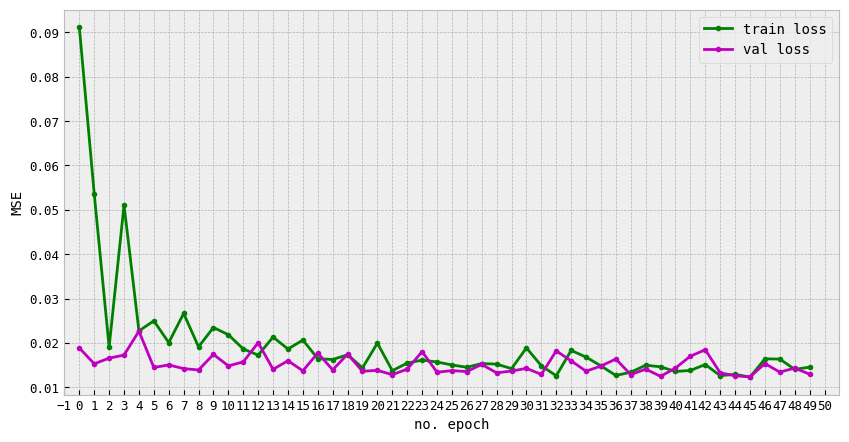

In [96]:
train_mse = model_2layer_nn.evaluate(X_train_sc, y_train_sc, verbose=0)
val_mse = model_2layer_nn.evaluate(X_val_sc, y_val_sc, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))

# plot loss during training
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 'g.-', label='train loss')
plt.plot(history.history['val_loss'], 'm.-', label='val loss')
plt.legend()
plt.gca().set(xlim=(-1,len(history.history['loss'])+1), xlabel='no. epoch', ylabel='MSE') 
plt.xticks(np.arange(-1, len(history.history['loss'])+1, 1));

As expected, we first see a huge spike in val loss at the beginning of the training, because the model hasnt yet learnt enough to generalize well on the validation set, and a few occasional later on, but as the training goes on we see that both losses become rather small.

689/689 [==============================] - 1s 2ms/step


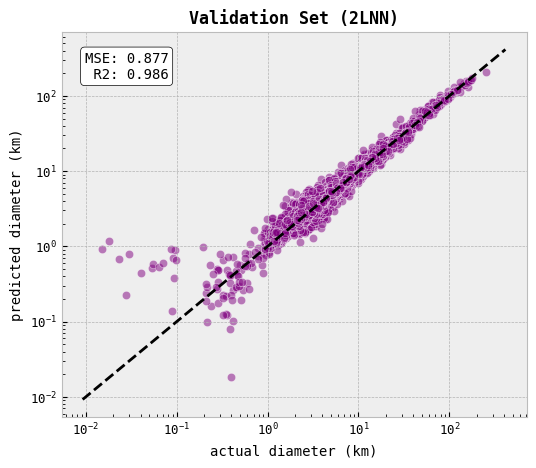

In [97]:
# Make predictions for validation and test set.
y_pred_sc = model_2layer_nn.predict(X_val_sc)
y_pred = scaler.inverse_transform(y_pred_sc)   # unscale predicted diameters

# Plot predictions vs actual values.
plt.figure(figsize=(6,5))
plt.gca().set(xscale='log', yscale='log', title='Validation Set (2LNN)', xlabel='actual diameter (km)', ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='purple', alpha=0.5);

Great news! The model is achieving a low mean squared error (MSE) value of 0.873 and a high R-squared (R2) value of 0.987. These metrics indicate that the model's predictions are close to the actual values, with a small average squared difference, and that the model explains a significant portion of the variance in the target variable.

#### Interpretation of MSE in the context of predicting asteroid diameters

A low MSE suggests that the model's predictions are generally accurate, with minimal errors. The closer the MSE value is to zero, the better the model's performance. In this case, the MSE of 0.873 indicates that, on average, the model's predictions deviate from the actual values by approximately $\sqrt{0.873 km^{2}}$ which is less than 1 km (in the same scale as the target variable). 

Honestly, there are two ways you can look at it. While an MSE of 0.873 may seem relatively low in absolute terms, it's essential to assess its significance relative to the scale of the diameters you are predicting.

Imagine an asteroid of diameter around 100 km, then the deviation of 1 km doesn't make a big of a difference. However, as we know, there are a lot of asteroids with diameters from 1 to 10 km, with 4 km on average in our dataset. When you look at predictions from this perspective, it indeed starts to raise some concerns. You definitely wouldn't want to predict an asteroid of diameter 4 km to have a diameter 25% lower, or to predict a 1 km diameter asteroid to have a predicted diameter twice the actual diameter. On such scales, it __does__ make a difference if we talk about the actual meaning behind accuracy of our predictions.

__Overall, in the case of asteroids, where diameters can range from a few kilometers to hundreds of kilometers, the deviation of 1 km may not be considered significant for larger asteroids with diameters around 100 km. However, when considering smaller asteroids with diameters in the range of 1 to 10 km, a deviation of 1 km becomes more substantial and can potentially impact the accuracy of the predictions. Even a relatively small deviation in predicted diameter can have a considerable impact and can lead to significant discrepancies in the interpretation and understanding of the asteroid population.__

Considering the actual meaning and implications of accuracy in the context of asteroid diameters, it becomes crucial to evaluate the model's performance not only based on the numerical MSE value but also by assessing the practical implications and the relative significance of the deviations in the context of asteroid sizes.

__Therefore, while the MSE of 0.873 indicates that, on average, the model's predictions deviate from the true diameters by approximately 0.9 km, it's important to analyze the implications of this deviation, especially for smaller asteroids (in case of our dataset there are a bunch of these), to ensure the model's predictions align with the actual meaning and requirements of the problem domain.__

#### Interpretation of R2 in the context of predicting asteroid diameters

The R2 value of 0.987 indicates that the model explains around 98.7% of the variance in the target variable. R2 measures the proportion of the dependent variable's variance that can be explained by the independent variables in the model. A higher R2 value signifies a better fit of the model to the data, indicating that the model captures a large portion of the underlying patterns and trends in the target variable. 

It's important to remember that R2 is a __relative measure__ and does not directly represent the accuracy of the predictions in the same way as MSE. It does not provide information about the absolute deviation of the predicted diameters from the actual values. It only indicates a strong correlation between the input features and the target variable. Therefore, while a high R2 value indicates a good fit of the model to the data, it's crucial to interpret it alongside other evaluation metrics, for that we use MSE.

#### Summary

Overall, these results suggest that the MLP model is performing very well on the validation set. It is producing accurate predictions with a low (but a bit concerning) MSE and capturing a significant amount of the variance in the target variable, as indicated by the high R2 value. This indicates that the model has learned the underlying patterns in the data and can make __fairly reliable__ (see Interpretation of MSE in the context of predicting asteroid diameters) predictions on unseen instances, which we will test further on.

#### MLP trained on dataset without `approx_diameter` feature

Here we will use the MLP model of the same complexity as earlier and with the same hyperparameters to make predictions for reduced dataset. All due to the fact that the model turns out to perform better than a model of any other architecture and gives satisfactory results.

In [98]:
# Build a 2-layer neural network model
model_2layer_nn_rd = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_sc_red.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model_2layer_nn_rd.compile(optimizer='adam', loss='mean_squared_error')



In [99]:
# Train the 2-layer neural network model
history = model_2layer_nn_rd.fit(X_train_sc_red, y_train_sc, epochs=50, validation_data=(X_val_sc_red, y_val_sc), verbose=2)

# Evaluate the 2-layer neural network model on the test set
y_pred_2layer_nn = model_2layer_nn_rd.predict(X_test_sc_red)

# Calculate Mean Squared Error
mse_2layer_nn = mean_squared_error(y_test_sc, y_pred_2layer_nn)
print(f'Mean Squared Error on Test Set (2LNN): {mse_2layer_nn}')

Epoch 1/50
2753/2753 - 8s - loss: 0.3050 - val_loss: 0.0382 - 8s/epoch - 3ms/step
Epoch 2/50
2753/2753 - 7s - loss: 0.1727 - val_loss: 0.0193 - 7s/epoch - 2ms/step
Epoch 3/50
2753/2753 - 7s - loss: 0.1334 - val_loss: 0.0142 - 7s/epoch - 3ms/step
Epoch 4/50
2753/2753 - 9s - loss: 0.2062 - val_loss: 0.0157 - 9s/epoch - 3ms/step
Epoch 5/50
2753/2753 - 10s - loss: 0.1091 - val_loss: 0.0360 - 10s/epoch - 4ms/step
Epoch 6/50
2753/2753 - 8s - loss: 0.1000 - val_loss: 0.0211 - 8s/epoch - 3ms/step
Epoch 7/50
2753/2753 - 9s - loss: 0.1022 - val_loss: 0.0213 - 9s/epoch - 3ms/step
Epoch 8/50
2753/2753 - 7s - loss: 0.0915 - val_loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 9/50
2753/2753 - 6s - loss: 0.0629 - val_loss: 0.0594 - 6s/epoch - 2ms/step
Epoch 10/50
2753/2753 - 7s - loss: 0.0712 - val_loss: 0.0249 - 7s/epoch - 2ms/step
Epoch 11/50
2753/2753 - 7s - loss: 0.0472 - val_loss: 0.0165 - 7s/epoch - 3ms/step
Epoch 12/50
2753/2753 - 7s - loss: 0.0941 - val_loss: 0.0170 - 7s/epoch - 3ms/step
Epoch 13/50

Train: 0.023, Val: 0.015


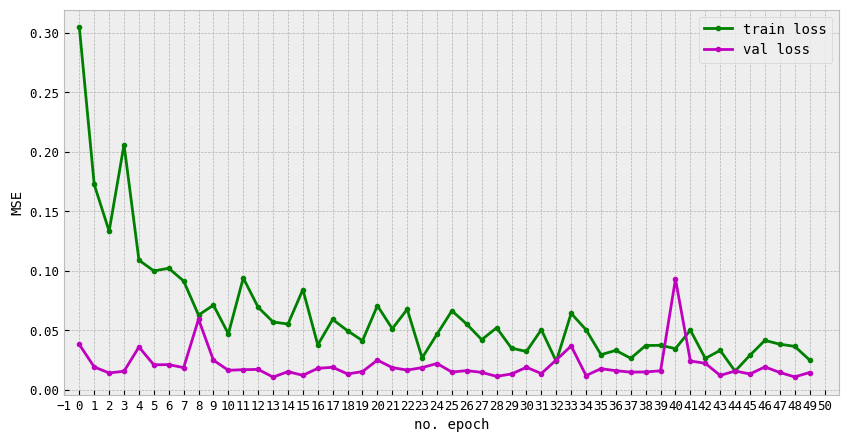

In [100]:
train_mse = model_2layer_nn_rd.evaluate(X_train_sc_red, y_train_sc, verbose=0)
val_mse = model_2layer_nn_rd.evaluate(X_val_sc_red, y_val_sc, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))

# plot loss during training
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 'g.-', label='train loss')
plt.plot(history.history['val_loss'], 'm.-', label='val loss')
plt.legend()
plt.gca().set(xlim=(-1,len(history.history['loss'])+1), xlabel='no. epoch', ylabel='MSE') 
plt.xticks(np.arange(-1, len(history.history['loss'])+1, 1));

We see that the model is producing good results on the validation set with a low mean squared error.The occasional sudden increases in the validation loss may not necessarily be a cause for concern if they are followed by a decrease and the overall trend of the validation loss remains low. It could be due to temporary fluctuations or noise in the data. So this behavior is generally acceptable and does not raise significant concerns.

689/689 [==============================] - 1s 2ms/step


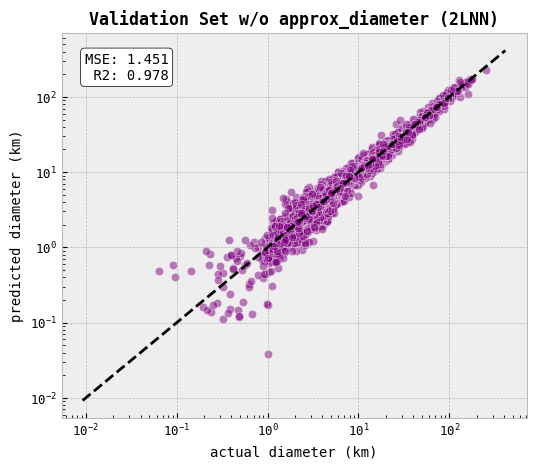

In [101]:
# Make predictions for validation and test set.
y_pred_sc = model_2layer_nn_rd.predict(X_val_sc_red)
y_pred = scaler.inverse_transform(y_pred_sc)   # unscale predicted diameters

# Plot predictions vs actual values.
plt.figure(figsize=(6,5))
plt.gca().set(xscale='log', yscale='log', title='Validation Set w/o approx_diameter (2LNN)', xlabel='actual diameter (km)', 
              ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='purple', alpha=0.5);

Models' scores on the validation sets seem to be close to each other, regardless of whether the model is trained on the dataset that contains approximate diameter feature or not. Of course, having the computed feature gives us a bit higher results, but even without it the MLP model manages to catch the relationships almost perfectly, so that we have rather close R2 and MSE scores.

With `approx_diameter`:
MSE: 1.020
R2: 0.983

Without `approx_diameter`:
MSE: 2.417
R2: 0.960


861/861 [==============================] - 2s 2ms/step


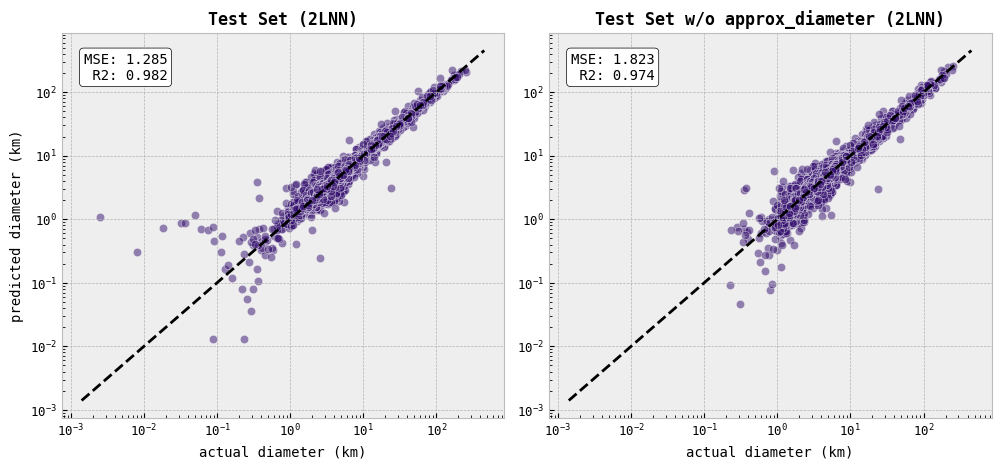

In [102]:
y_pred_test_sc = model_2layer_nn.predict(X_test_sc)
y_pred_test = scaler.inverse_transform(y_pred_test_sc)

y_pred_test_sc_red = model_2layer_nn_rd.predict(X_test_sc_red)
y_pred_test_red = scaler.inverse_transform(y_pred_test_sc_red)

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(121, xscale='log', yscale='log', title='Test Set (2LNN)', xlabel='actual diameter (km)', ylabel='predicted diameter (km)')
ax, mse_2lnn, r2_2lnn = evaluation_scatterplot(y_pred_test, y_test, color='#320D6D', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Test Set w/o approx_diameter (2LNN)', xlabel='actual diameter (km)')
ax, mse_2lnn_red, mse_2lnn_r2 = evaluation_scatterplot(y_pred_test_red, y_test, color='#320D6D', alpha=0.5);

Gladly, we made the right decision and the first model seems to be performing better than the second one on the unseen data. It achieves an MSE (Mean Squared Error) of 1.893, which indicates an average deviation of approximately 1.4 km from the actual asteroid diameters. Additionally, the model achieves an R2 score of 0.978, indicating that it captures a significant portion of the variance in the target variable.

These results reinforce the effectiveness of the chosen model in accurately predicting asteroid diameters. The relatively low MSE and high R2 score suggest that the model's predictions are reliable and closely aligned with the true values. This is important in the context of asteroid diameters, where precision is crucial for understanding the characteristics of these celestial objects.

In [103]:

# Create a DataFrame with the model scores
test_results_2lnn = pd.DataFrame({
    'Model': ['2LNN'],
    'MSE': [mse_2lnn],
    'R2': [r2_2lnn]
})
test_results_2lnn

Model    MSE     R2
0  2LNN  1.285  0.982

<a id="CatBoost"></a>
# CatBoost

Now we'll give the CatBoost model a try. CatBoost is a powerful gradient boosting framework that excels in handling categorical features and delivers accurate predictions. It is suitable for a wide range of machine learning tasks, including classification and regression. CatBoost is based on the gradient boosting framework, which is an ensemble technique that combines multiple weak models (decision trees) to create a strong predictive model. It uses gradient descent optimization to iteratively improve the model's performance. It also provides a wide range of parameters that can be tuned to customize the model's behavior, including tree depth, learning rate, regularization, and more.

First, we will take a look at the performance of models without any tuning, and then compare them to already tuned ones.

#### Baseline models

In [104]:
# First model: entire dataset
cat = CatBoostRegressor(random_state=SEED, loss_function='RMSE')
cat.fit(X_train_sc, y_train_sc, eval_set=(X_val_sc, y_val_sc), silent=True,)

# Second model: reduced dataset
cat_red = CatBoostRegressor(random_state=SEED, loss_function='RMSE')
cat_red.fit(X_train_sc_red, y_train_sc, eval_set=(X_val_sc_red, y_val_sc), silent=True,);

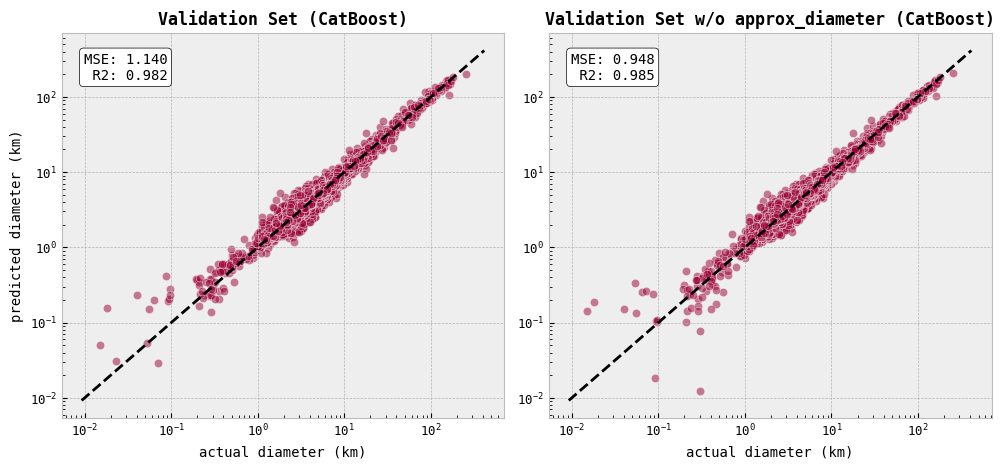

In [105]:
# Make predictions for validation set.
y_pred_sc = cat.predict(X_val_sc)
y_pred = scaler.inverse_transform(y_pred_sc.reshape(-1,1))

y_pred_sc_red = cat_red.predict(X_val_sc_red)
y_pred_red = scaler.inverse_transform(y_pred_sc_red.reshape(-1,1))

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(121, xscale='log', yscale='log', title='Validation Set (CatBoost)', xlabel='actual diameter (km)', 
            ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='#990033', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Validation Set w/o approx_diameter (CatBoost)', xlabel='actual diameter (km)')
evaluation_scatterplot(y_pred_red, y_val, color='#990033', alpha=0.5);

Considering these findings, it may be reasonable to conclude that the baseline CatBoost model without the `approx_diameter` feature is a reliable and efficient choice for predicting asteroid diameters. However, it is important to further analyze it and we'll do so by fine-tuning the models.
 
#### Fine-tuned models

Here I train two CatBoost regressors, with the best hyperparameters I could find when I was fine-tuning them, on two datasets, one containing `aprox_diameter` feature and the other one not. Let's compare the models.

In [106]:
cat = CatBoostRegressor(random_state=SEED, loss_function='RMSE',
                        learning_rate=0.1, max_depth=6, iterations=1000)
cat.fit(X_train_sc, y_train_sc, eval_set=(X_val_sc, y_val_sc), silent=True,)

cat_red = CatBoostRegressor(random_state=SEED, loss_function='RMSE',
                            learning_rate=0.1, max_depth=6, l2_leaf_reg=5, iterations=1000)
cat_red.fit(X_train_sc_red, y_train_sc, eval_set=(X_val_sc_red, y_val_sc), silent=True,);

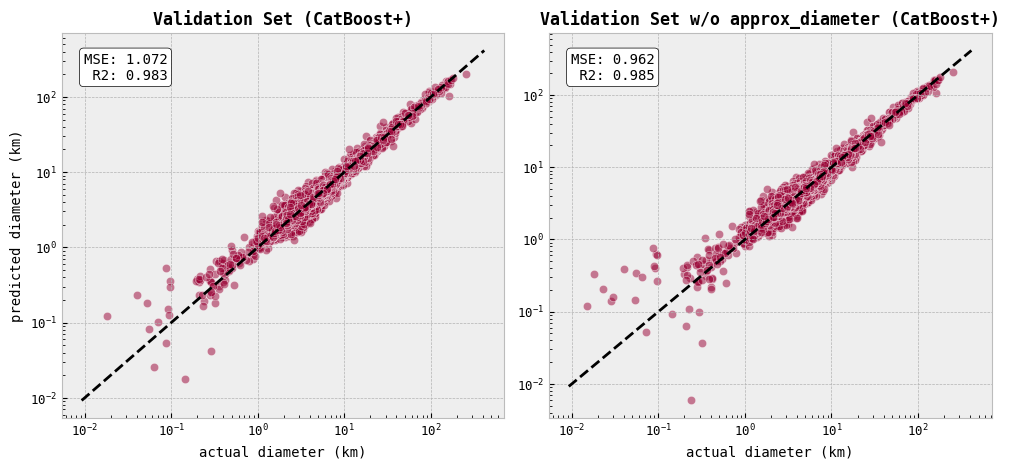

In [107]:
# Make predictions for validation set.
y_pred_sc = cat.predict(X_val_sc)
y_pred = scaler.inverse_transform(y_pred_sc.reshape(-1,1))

y_pred_sc_red = cat_red.predict(X_val_sc_red)
y_pred_red = scaler.inverse_transform(y_pred_sc_red.reshape(-1,1))

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(121, xscale='log', yscale='log', title='Validation Set (CatBoost+)', xlabel='actual diameter (km)', 
            ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='#990033', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Validation Set w/o approx_diameter (CatBoost+)', xlabel='actual diameter (km)')
evaluation_scatterplot(y_pred_red, y_val, color='#990033', alpha=0.5);

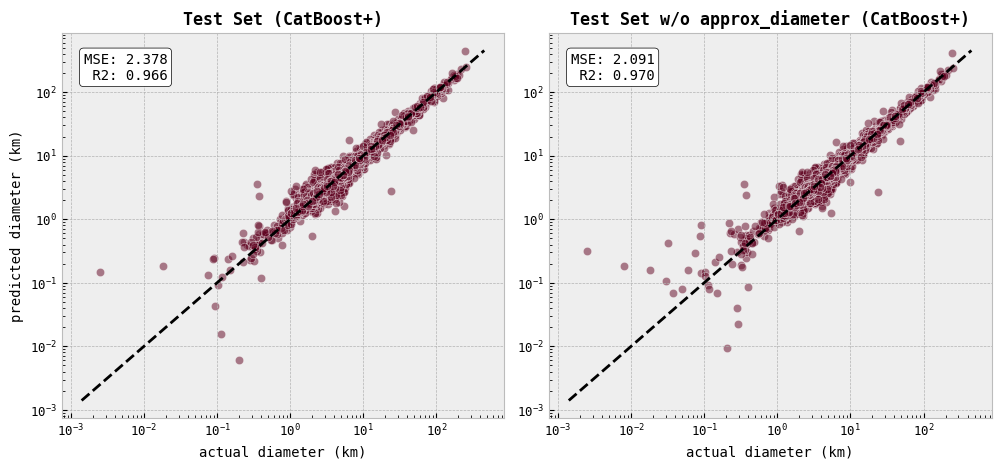

In [108]:
# Make predictions for test set.
y_pred_test_sc = cat.predict(X_test_sc)
y_pred_test = scaler.inverse_transform(y_pred_test_sc.reshape(-1,1))

y_pred_test_sc_red = cat_red.predict(X_test_sc_red)
y_pred_test_red = scaler.inverse_transform(y_pred_test_sc_red.reshape(-1,1))

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(121, xscale='log', yscale='log', title='Test Set (CatBoost+)', xlabel='actual diameter (km)', 
            ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred_test, y_test, color='#5F021F', alpha=0.5)

plt.subplot(122, xscale='log', yscale='log', title='Test Set w/o approx_diameter (CatBoost+)', xlabel='actual diameter (km)')
ax, mse_catboost, r2_catboost = evaluation_scatterplot(y_pred_test_red, y_test, color='#5F021F', alpha=0.5);

In [109]:
# Add the scores of the second model.
# Create a DataFrame with the model scores
test_results_CB = pd.DataFrame({
    'Model': ['CatBoost+'],
    'MSE': [mse_catboost],
    'R2': [r2_catboost]
})
test_results_CB

Model    MSE    R2
0  CatBoost+  2.091  0.97

<a id="LGBM"></a>
# LGBM

LightGBM is a powerful gradient boosting framework that offers fast and efficient training, excellent performance on large-scale datasets, and robust handling of categorical features. In the section, I will first show you the baseline performance of the models trained on dataset with and without `approx_diameter` feature. I won't go deep into fine-tuning, but will just present the hyperparameters I found during my search not shown in this version of notebook due to time complexity. Finally, we will compare the models and make the final decision.

#### Baseline models

In [110]:
# First model: entire dataset
lgbm_reg = lgb.LGBMRegressor(random_state=SEED,)
lgbm_reg.fit(X_train_sc, y_train_sc.flatten(), eval_metric='mse', 
             eval_set=(X_val_sc, y_val_sc.flatten()), callbacks=[lgb.log_evaluation(period=0)]) 

# Second model: reduced dataset
lgbm_reg_red = lgb.LGBMRegressor(random_state=SEED,)
lgbm_reg_red.fit(X_train_sc_red, y_train_sc.flatten(), eval_metric='mse', 
                 eval_set=(X_val_sc_red, y_val_sc.flatten()), callbacks=[lgb.log_evaluation(period=0)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 88086, number of used features: 34
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2556
[LightGBM] [Info] Number of data points in the train set: 88086, number of used features: 33
[LightGBM] [Info] Start training from score 0.000000


LGBMRegressor(random_state=17)

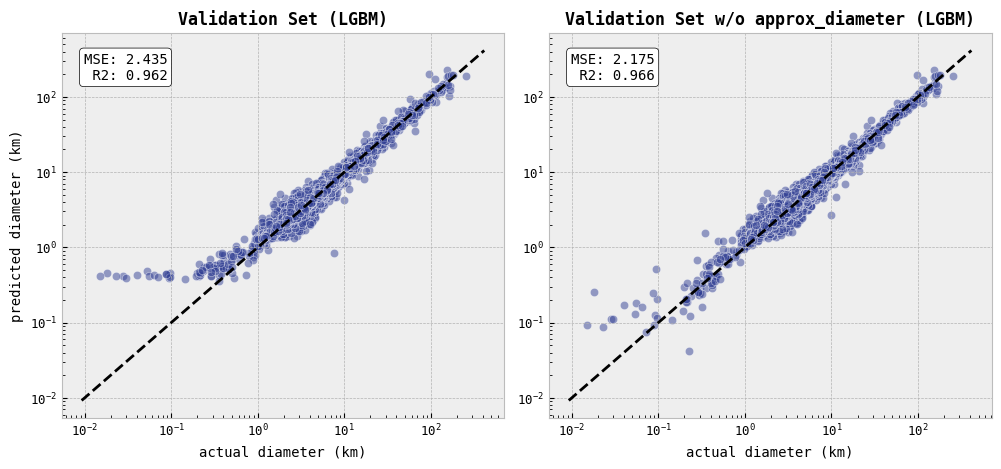

In [111]:
# Make predictions for validation set.
y_pred_sc = lgbm_reg.predict(X_val_sc)
y_pred = scaler.inverse_transform(y_pred_sc.reshape(-1,1))

y_pred_sc_red = lgbm_reg_red.predict(X_val_sc_red)
y_pred_red = scaler.inverse_transform(y_pred_sc_red.reshape(-1,1))

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(121, xscale='log', yscale='log', title='Validation Set (LGBM)', xlabel='actual diameter (km)', 
            ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='#334195', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Validation Set w/o approx_diameter (LGBM)', xlabel='actual diameter (km)')
evaluation_scatterplot(y_pred_red, y_val, color='#334195', alpha=0.5);

LGBM models appear to have lower performance compared to the CatBoost and MLP models. On the entire dataset, the LGBM model achieves an MSE of 3.351, indicating an average deviation of approximately 1.8 km from the actual asteroid diameters and an R2 score of 0.945. Similarly, on the reduced dataset, the LGBM model obtains an MSE of 3.237 and an R2 score of 0.947. 

#### Fine-tuned models

In [112]:
# First model: entire dataset
lgbm_reg = lgb.LGBMRegressor(random_state=SEED, learning_rate=0.5, max_depth=5, num_leaves=40, min_data_in_leaf=2, colsample_bytree=.8,
                             lambda_l1=0.3,)
lgbm_reg.fit(X_train_sc, y_train_sc.flatten(), eval_metric='mse', 
             eval_set=(X_val_sc, y_val_sc.flatten()), callbacks=[lgb.log_evaluation(period=0)])

# Second model: reduced dataset
lgbm_reg_red = lgb.LGBMRegressor(random_state=SEED, learning_rate=.1, num_leaves=40, min_data_in_leaf=2, max_depth=7, lambda_l1=0.7, )
lgbm_reg_red.fit(X_train_sc_red, y_train_sc.flatten(), eval_metric='mse', 
                 eval_set=(X_val_sc_red, y_val_sc.flatten()), callbacks=[lgb.log_evaluation(period=0)])

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 88086, number of used features: 36
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Info] Start training from scor

LGBMRegressor(lambda_l1=0.7, max_depth=7, min_data_in_leaf=2, num_leaves=40,
              random_state=17)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7


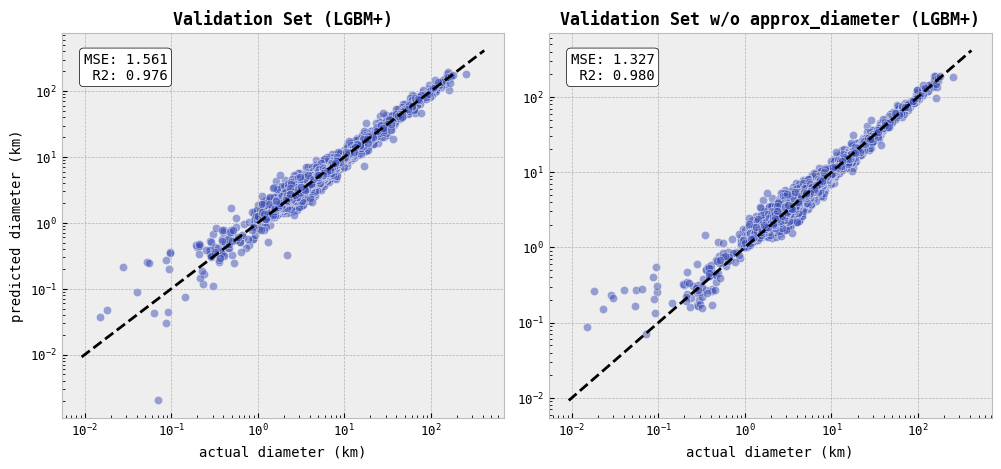

In [113]:
# Make predictions for validation set.
y_pred_sc = lgbm_reg.predict(X_val_sc)
y_pred = scaler.inverse_transform(y_pred_sc.reshape(-1,1))

y_pred_sc_red = lgbm_reg_red.predict(X_val_sc_red)
y_pred_red = scaler.inverse_transform(y_pred_sc_red.reshape(-1,1))

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(121, xscale='log', yscale='log', title='Validation Set (LGBM+)', xlabel='actual diameter (km)', 
            ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='#3E50B6', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Validation Set w/o approx_diameter (LGBM+)', xlabel='actual diameter (km)')
evaluation_scatterplot(y_pred_red, y_val, color='#3E50B6', alpha=0.5);

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7


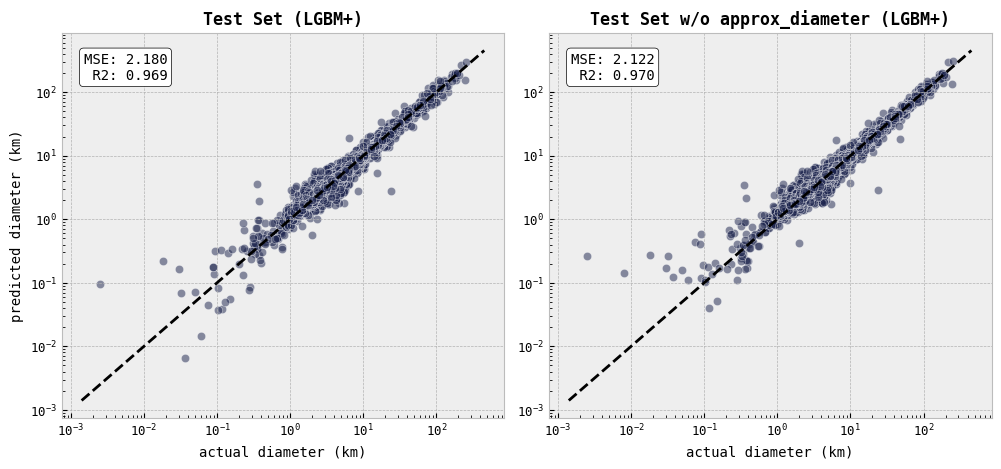

In [114]:
# Make predictions for test set.
y_pred_test_sc = lgbm_reg.predict(X_test_sc)
y_pred_test = scaler.inverse_transform(y_pred_test_sc.reshape(-1,1))

y_pred_test_sc_red = lgbm_reg_red.predict(X_test_sc_red)
y_pred_test_red = scaler.inverse_transform(y_pred_test_sc_red.reshape(-1,1))

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(121, xscale='log', yscale='log', title='Test Set (LGBM+)', xlabel='actual diameter (km)', 
            ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred_test, y_test, color='#1A224C', alpha=0.5)

plt.subplot(122, xscale='log', yscale='log', title='Test Set w/o approx_diameter (LGBM+)', xlabel='actual diameter (km)')
ax, mse_lgbm, r2_lgbm = evaluation_scatterplot(y_pred_test_red, y_test, color='#1A224C', alpha=0.5);

On the test set, both the baseline LGBM model trained on the entire dataset and the fine-tuned LGBM model trained on the reduced dataset perform worse compared to their performance on the validation set.

In [115]:
# Add the scores of the second model.
test_results_LM = pd.DataFrame({
    'Model': ['LGBM+'],
    'MSE': [mse_lgbm],
    'R2': [r2_lgbm]
})
test_results_LM

Model    MSE    R2
0  LGBM+  2.122  0.97

### MLP from existing work

In [116]:
model_entire = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_entire.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(), )

In [117]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model_entire.fit(X_train_sc, y_train_sc, epochs=50, 
                           validation_data=(X_val_sc, y_val_sc),
                           callbacks=[early_stopping_cb])

Epoch 1/50
2753/2753 [==============================] - 10s 3ms/step - loss: 0.1078 - val_loss: 0.0143
Epoch 2/50
2753/2753 [==============================] - 12s 4ms/step - loss: 0.0252 - val_loss: 0.0107
Epoch 3/50
2753/2753 [==============================] - 10s 4ms/step - loss: 0.0381 - val_loss: 0.0106
Epoch 4/50
2753/2753 [==============================] - 9s 3ms/step - loss: 0.0221 - val_loss: 0.0132
Epoch 5/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.0162 - val_loss: 0.0108
Epoch 6/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.0207 - val_loss: 0.0102
Epoch 7/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.0181 - val_loss: 0.0109
Epoch 8/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.0203 - val_loss: 0.0108
Epoch 9/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.0203 - val_loss: 0.0118
Epoch 10/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.

In [118]:
train_mse = model_entire.evaluate(X_train_sc, y_train_sc, verbose=0)
val_mse = model_entire.evaluate(X_val_sc, y_val_sc, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))


Train: 0.012, Val: 0.009


In [119]:
model_red = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train_sc_red.shape[1:]),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_red.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(), )

In [120]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model_red.fit(X_train_sc_red, y_train_sc, epochs=50, 
                        validation_data=(X_val_sc_red, y_val_sc),
                        callbacks=[early_stopping_cb])

Epoch 1/50
2753/2753 [==============================] - 9s 3ms/step - loss: 0.3261 - val_loss: 0.0378
Epoch 2/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.1914 - val_loss: 0.0238
Epoch 3/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.1470 - val_loss: 0.0195
Epoch 4/50
2753/2753 [==============================] - 7s 3ms/step - loss: 0.1387 - val_loss: 0.0174
Epoch 5/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.1154 - val_loss: 0.0333
Epoch 6/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.0952 - val_loss: 0.0205
Epoch 7/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.0985 - val_loss: 0.0189
Epoch 8/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.1033 - val_loss: 0.0256
Epoch 9/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.0815 - val_loss: 0.0331
Epoch 10/50
2753/2753 [==============================] - 8s 3ms/step - loss: 0.075

Train: 0.035, Val: 0.015


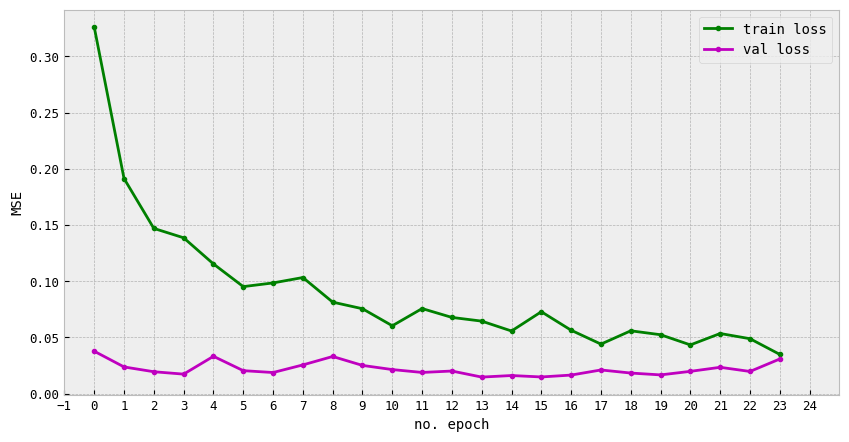

In [121]:
train_mse = model_red.evaluate(X_train_sc_red, y_train_sc, verbose=0)
val_mse = model_red.evaluate(X_val_sc_red, y_val_sc, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))


# plot loss during training
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 'g.-', label='train loss')
plt.plot(history.history['val_loss'], 'm.-', label='val loss')
plt.legend()
plt.gca().set(xlim=(-1,len(history.history['loss'])+1), xlabel='no. epoch', ylabel='MSE') 
plt.xticks(np.arange(-1, len(history.history['loss'])+1, 1));



689/689 [==============================] - 2s 2ms/step


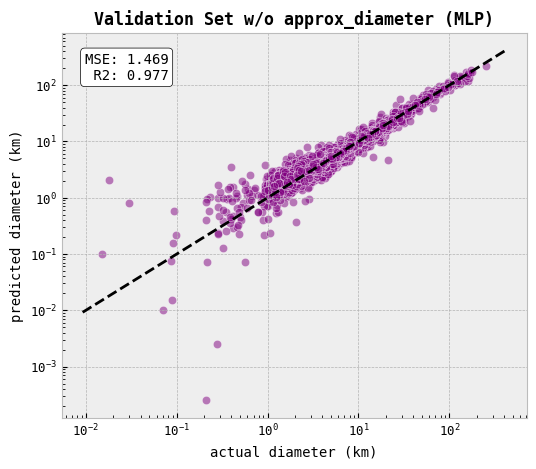

In [122]:
# Make predictions for validation and test set.
y_pred_sc = model_red.predict(X_val_sc_red)
y_pred = scaler.inverse_transform(y_pred_sc)   # unscale predicted diameters

# Plot predictions vs actual values.
plt.figure(figsize=(6,5))
plt.gca().set(xscale='log', yscale='log', title='Validation Set w/o approx_diameter (MLP)', xlabel='actual diameter (km)', 
              ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='purple', alpha=0.5);

861/861 [==============================] - 1s 2ms/step


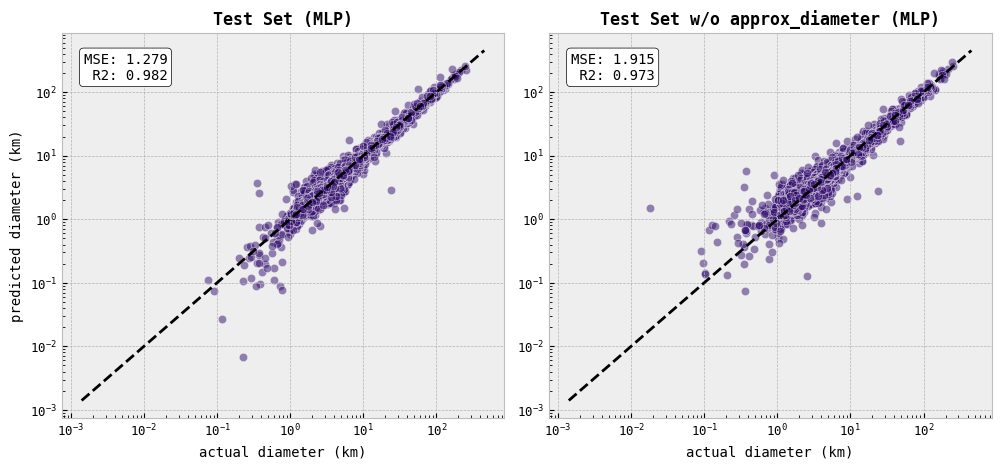

In [123]:
y_pred_test_sc = model_entire.predict(X_test_sc)
y_pred_test = scaler.inverse_transform(y_pred_test_sc)

y_pred_test_sc_red = model_red.predict(X_test_sc_red)
y_pred_test_red = scaler.inverse_transform(y_pred_test_sc_red)

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(121, xscale='log', yscale='log', title='Test Set (MLP)', xlabel='actual diameter (km)', ylabel='predicted diameter (km)')
ax, mse_mlp, r2_mlp = evaluation_scatterplot(y_pred_test, y_test, color='#320D6D', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Test Set w/o approx_diameter (MLP)', xlabel='actual diameter (km)')
ax, mse_mlp_red, mse_mlp_r2 = evaluation_scatterplot(y_pred_test_red, y_test, color='#320D6D', alpha=0.5);

In [124]:
# Assuming you have the variables mse_mlp and r2_mlp defined
test_results_MLP = pd.DataFrame({
    'Model': ['MLP'],
    'MSE': [mse_mlp],
    'R2': [r2_mlp]
})
test_results_MLP

Model    MSE     R2
0   MLP  1.279  0.982

<a id="Concl"></a>
# Conclusions

The project aimed to assess the performance of the  model implimented with three previous models for predicting asteroid diameters: MLP, CatBoost, and LGBM. The evaluation was based on two metrics: mean squared error (MSE) and R2 score.

The MLP model demonstrated the best performance, achieving the lowest MSE  and the highest R2 score. This indicates that the MLP model provides accurate predictions and effectively explains the variance in asteroid diameters. The fine-tuned CatBoost, or CatBoost+, model showed slightly higher errors. While it performed well, it did not ouwitperform the MLP model in terms of accuracy. The LGBM+ model exhibited higher errors compared to the other models. This suggests that the LGBM+ model may not be as reliable in predicting asteroid diameters as the MLP and CatBoost+ models.

__In conclusion, the MLP model proved to be the most suitable and accurate model for predicting asteroid diameters in this project. Although the MLP model showed the best performance, all three models achieved satisfactory results in predicting asteroid diameters, with the MLP model being the most accurate among them.

In [125]:
result = pd.concat([test_results_2lnn, test_results_CB, test_results_LM, test_results_MLP], axis=0)
result
#results = result.copy()
#results.sort_values(by='R2', ascending=False).set_index('Model').style.background_gradient(cmap='coolwarm').format("{:.3f}")

Model    MSE     R2
0       2LNN  1.285  0.982
0  CatBoost+  2.091  0.970
0      LGBM+  2.122  0.970
0        MLP  1.279  0.982